# **프로젝트 루브릭**

# **10 노드 루브릭**

목표: 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 잘 이루어졌다.
  - 데이터 정제, SentencePiece를 활용한 토큰화 및 데이터셋 구축의 과정이 지시대로 진행되었다.

목표: Transformer 번역기 모델이 정상적으로 구동된다.
  - Transformer 모델의 학습과 추론 과정이 정상적으로 진행되어, 한-영 번역기능이 정상 동작한다.

목표: 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.
  - 제시된 문장에 대한 그럴듯한 영어 번역문이 생성되며, 시각화된 Attention Map으로 결과를 뒷받침한다.


# **12 노드 루브릭**

목표: 챗봇 훈련데이터 전처리 과정이 체계적으로 진행되었는가?
  - 챗봇 훈련데이터를 위한 전처리와 augmentation이 적절히 수행되어 3만개 가량의 훈련데이터셋이 구축되었다.

목표: transformer 모델을 활용한 챗봇 모델이 과적합을 피해 안정적으로 훈련되었는가?
  - 과적합을 피할 수 있는 하이퍼파라미터 셋이 적절히 제시되었다.

목표: 챗봇이 사용자의 질문에 그럴듯한 형태로 답하는 사례가 있는가?
  - 주어진 예문을 포함하여 챗봇에 던진 질문에 적절히 답하는 사례가

# **프로젝트 진행과정**
1. 팀 베이스 코드 선정
2. 팀 베이스 코드를 중심으로 개별 보완/ 실험 진행
3. 이영석은 여러 증강라이브러리를 비교 실험 시도 - Ko.bin 시도(고용량 부적합 판단) -> KoEDA(가볍고 실험측면에 용이) 선정함
4. 모델 결과를 놓고 원인 분석 및 성능 개선 방안 검토
5. 성능 개선 방향에 대한 추가 실험

# **프로젝트의 주요 산출물**

산출물을 통해 분석해보면 제대로 학습이 이루어지지 않았다고 평가된다

      MODEL_CONFIG = EasyDict({
          'emb_dim': 256,       # 임베딩 차원
          'ffn_dim': 1024,      # Feed-Forward 차원
          'num_heads': 8,       # 어텐션 헤드 수
          'encoder_layers': 6,  # 인코더 레이어 수
          'decoder_layers': 6,  # 디코더 레이어 수
          'dropout': 0.1,
          'attention_dropout': 0.1,
          'max_position_embeddings': 100,
      })

      TRAIN_CONFIG = EasyDict({
          'num_epochs': 30,     # 에폭 수
          'learning_rate': 0.0005,
          'betas': (0.9, 0.98),
          'eps': 1e-9,
          'weight_decay': 0.01,
          'clip': 1.0,          # 그래디언트 클리핑
          'label_smoothing': 0.1,
          'patience': 3,        # Early Stopping
          'min_delta': 1e-4,

      최종 Train Loss: 2.3733
      최종 Val Loss: 2.9288
      Best Val Loss: 2.9234

      최종 평가 결과:
        BLEU:      0.0000
        METEOR:    0.0112
        ROUGE-L:   0.0363
        BERTScore: 0.7163

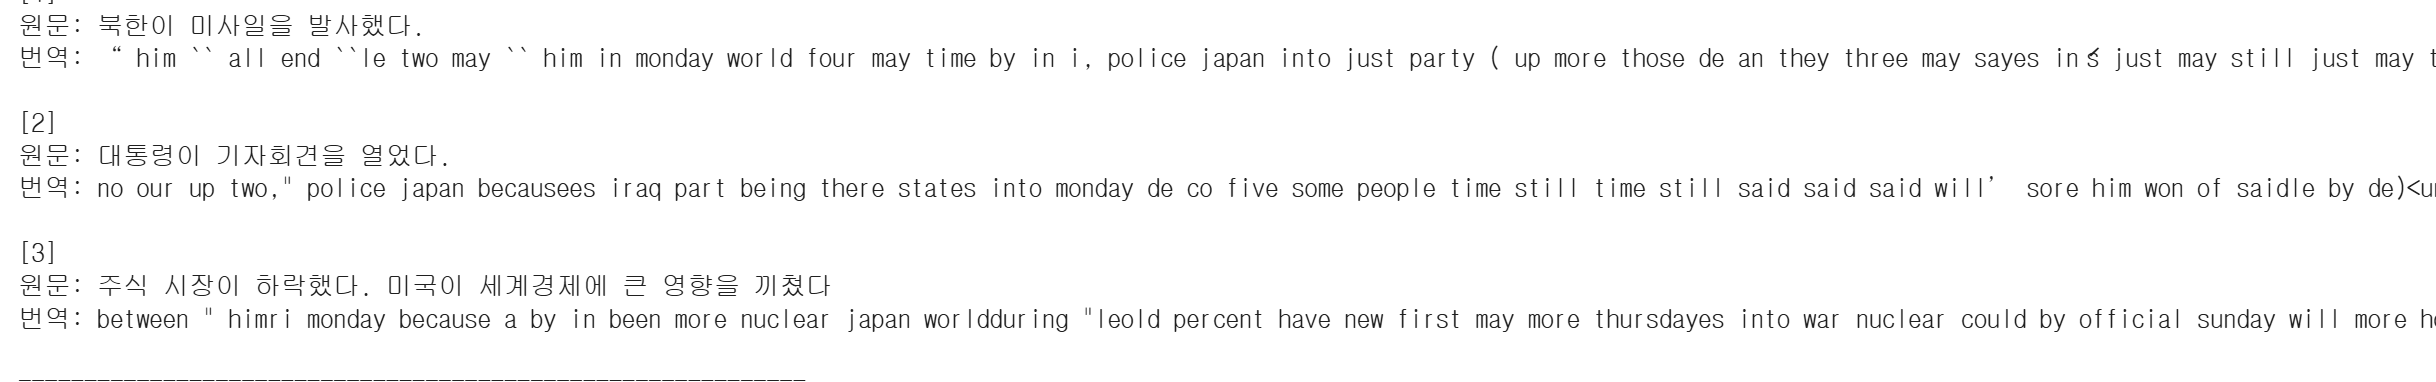

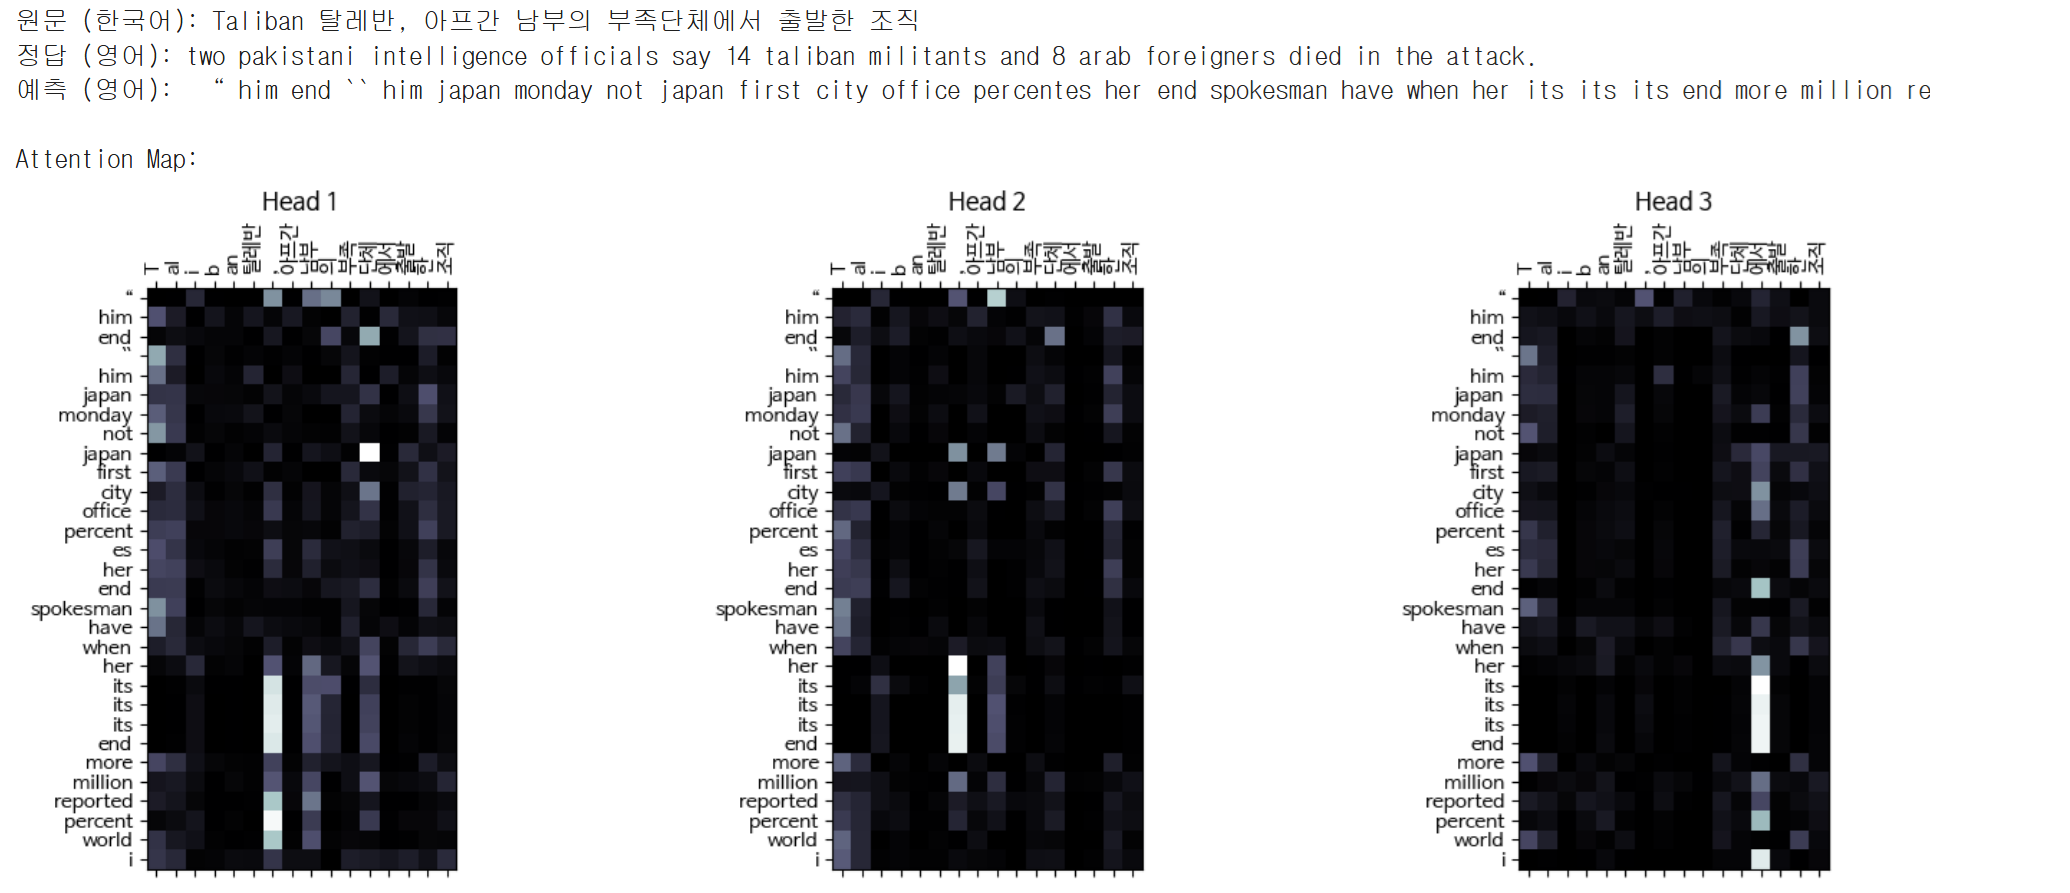

# **프로젝트 결과에 대한 Key Findings 및 개선방향 **

학습이 제대로 이루어지지 못한 이유에 대한 가설

  가설1) 전처리가 제대로 이루어지지 못했다
  가설2) 모델의 주요 모듈이 제대로 작동하지 못한다
    - 가설 2-1) 인풋 인코딩에 에러가 있다 -> 스케일링 missing 발견
    - 가설 2-1) 멀티헤더 어텐션에 에러가 있다->  스케일링 missing 발견
  가설3) data 증강 등을 통해서 학습이 더 진행하도록 진행해본다.
  가설4)

# **회고**

# 영어-한국어 번역 Transformer



# 1. 환경 설정


In [1]:
# 기본 라이브러리
import os
import re
import math
import time
import random
from typing import List, Tuple, Dict

# 데이터 처리
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
try:
    from nltk.corpus import wordnet
    wordnet.synsets('test')  # WordNet 사용 가능 여부 확인
except LookupError:
    print("WordNet 다운로드 중...")
    nltk.download('wordnet', quiet=True)
    nltk.download('omw-1.4', quiet=True)
    from nltk.corpus import wordnet

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# SentencePiece
import sentencepiece as spm

# 시각화
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rc

# 평가
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# 진행바
from tqdm import tqdm

# 설정
from easydict import EasyDict

# 경고 무시
import warnings
warnings.filterwarnings('ignore')

# 디바이스 설정
device = torch.device('mps' if torch.backends.mps.is_available() else
                     'cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

!pip install gensim
from gensim.models import KeyedVectors
import gensim.downloader as api
GENSIM_AVAILABLE = True
# 랜덤 시드 설정
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

Using device: cuda


In [24]:
# 데이터 다운로드 및 확인, 디렉토리 정의

# 작업 디렉토리 설정
dataset_dir = os.path.join(os.path.expanduser("/content/work/dataset"))
os.makedirs(dataset_dir, exist_ok=True)

# 1. 데이터 다운로드
print("데이터 다운로드 중...")
!wget -q https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz -P {dataset_dir}

# 2. gzip 압축 해제
print("gzip 압축 해제 중...")
!gzip -d {dataset_dir}/korean-english-park.train.tar.gz

# 3. tar 아카이브 추출
print("tar 추출 중...")
!tar -xvf {dataset_dir}/korean-english-park.train.tar -C {dataset_dir}

# 파일 경로 설정
kor_path = os.path.join(dataset_dir, "korean-english-park.train.ko")
eng_path = os.path.join(dataset_dir, "korean-english-park.train.en")
save_path = dataset_dir

# 4. 데이터 읽기
with open(kor_path, 'r', encoding='utf-8') as f:
    questions = [line.strip() for line in f.readlines()]  # 한국어 (소스)

with open(eng_path, 'r', encoding='utf-8') as f:
    answers = [line.strip() for line in f.readlines()]  # 영어 (타겟)

# 5. 확인
print(f"\n다운로드 완료!")
print(f"한국어 문장 개수: {len(questions)}")
print(f"영어 문장 개수: {len(answers)}")
print(f"\n예시:")
for i in range(3):
    print(f"Kor: {questions[i]}")
    print(f"Eng: {answers[i]}")
    print("-" * 50)

# ```
# ## 결과 변수

# | 변수 | 내용 | 용도 |
# |------|------|------|
# | `questions` | 한국어 문장 리스트 | 소스 (인코더 입력) |
# | `answers` | 영어 문장 리스트 | 타겟 (디코더 출력) |

# ## 데이터 구조
# ```
# questions[0]: "북한의 핵 전문가들이 영변에 있는..."
# answers[0]: "North Korea's nuclear experts have been..."

데이터 다운로드 중...
gzip 압축 해제 중...
gzip: /content/work/dataset/korean-english-park.train.tar already exists; do you wish to overwrite (y or n)? n
	not overwritten
tar 추출 중...
korean-english-park.train.en
korean-english-park.train.ko

다운로드 완료!
한국어 문장 개수: 94123
영어 문장 개수: 94123

예시:
Kor: 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
Eng: Much of personal computing is about "can you top this?"
--------------------------------------------------
Kor: 모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.
Eng: so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable, wireless mouse.
--------------------------------------------------
Kor: 그러나 이것은 또한 책상도 필요로 하지 않는다.
Eng: Like all optical mice, But it also doesn't need a desk.
--------------------------------------------------


# **2. 탐색적 EDA와 전처리**

설정된 폰트: ['NanumBarunGothic']
한글 테스트: 가나다라마바사
📊 한영 병렬 코퍼스 EDA
분석 일시: 2025-11-26 15:58:55

[ 1. 기본 정보 ]
한국어 문장 수: 94,123
영어 문장 수: 94,123
병렬 쌍 일치 여부: ✓ 일치

[ 2. 문장 길이 분석 (문자 수) ]

한국어:
  - 평균: 60.8자
  - 중앙값: 59.0자
  - 최소: 1자
  - 최대: 377자
  - 표준편차: 29.8

영어:
  - 평균: 126.1자
  - 중앙값: 121.0자
  - 최소: 1자
  - 최대: 605자
  - 표준편차: 64.4

[ 3. 문장 길이 분석 (단어 수) ]

한국어 (공백 기준):
  - 평균: 14.0단어
  - 중앙값: 14.0단어
  - 최소: 1단어
  - 최대: 82단어

영어:
  - 평균: 20.9단어
  - 중앙값: 20.0단어
  - 최소: 1단어
  - 최대: 90단어

[ 4. 어휘(Vocabulary) 분석 ]

한국어:
  - 전체 단어 수: 1,322,152
  - 고유 단어 수 (Vocabulary): 241,552

영어:
  - 전체 단어 수: 1,966,859
  - 고유 단어 수 (Vocabulary): 110,099

[ 5. 상위 빈출 단어 ]

한국어 Top 10:
  이: 7,920회
  밝혔다.: 7,838회
  말했다.: 6,953회
  있다.: 6,942회
  수: 6,301회
  있는: 6,067회
  그는: 5,124회
  대한: 4,406회
  위해: 4,272회
  전했다.: 3,817회

영어 Top 10:
  the: 109,097회
  to: 53,871회
  of: 51,188회
  a: 45,948회
  in: 44,377회
  and: 42,495회
  for: 17,523회
  on: 17,088회
  The: 16,967회
  that: 16,527회

[ 6. 샘플 데이터 ]
-------------------------------

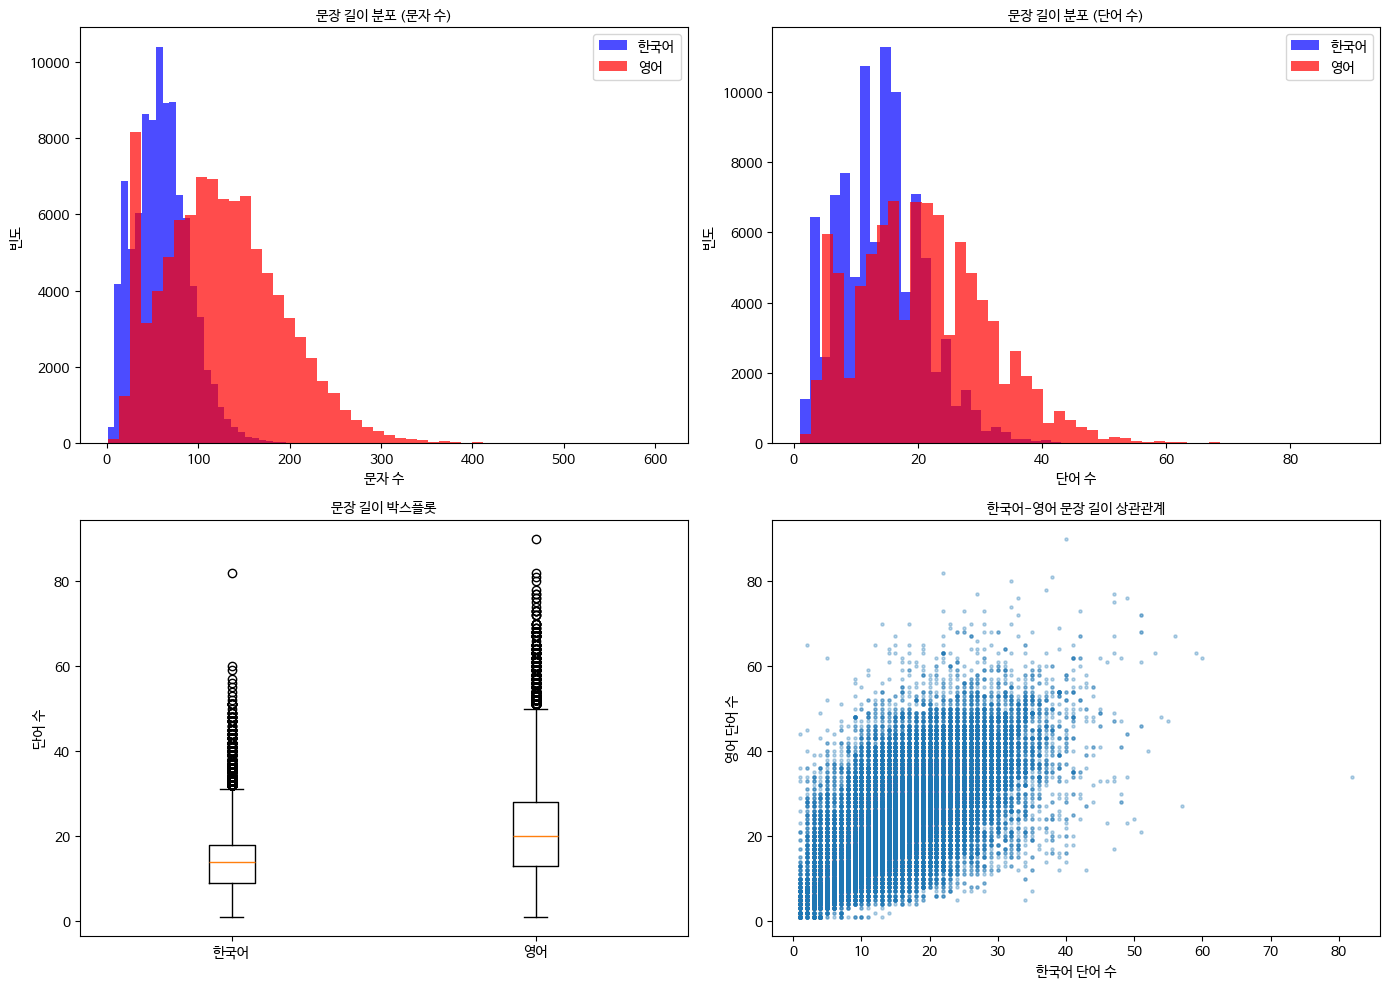


📁 시각화 저장: /content/work/dataset/eda_visualization.png
📁 텍스트 리포트 저장: /content/work/dataset/eda_report.txt
📁 요약 통계 CSV 저장: /content/work/dataset/eda_summary.csv

✅ 모든 EDA 결과가 /content/work/dataset에 저장되었습니다.


In [12]:
# data 기초 분석
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from datetime import datetime
import matplotlib.font_manager as fm

# ========================================
# 한글 폰트 설정 (Colab용) - 강화된 버전
# ========================================
!apt-get install -y fonts-nanum > /dev/null 2>&1

# 폰트 캐시 삭제 및 재생성
!rm -rf ~/.cache/matplotlib/*

# 폰트 경로 직접 지정
font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_prop = fm.FontProperties(fname=font_path)

# matplotlib 폰트 매니저에 폰트 추가
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

# 폰트 설정 확인
print(f"설정된 폰트: {plt.rcParams['font.family']}")
print("한글 테스트: 가나다라마바사")

# ========================================
# EDA 시작
# ========================================

# 결과 저장용 리스트
eda_results = []

def log(text):
    """화면 출력 및 결과 저장"""
    print(text)
    eda_results.append(text)

log("=" * 60)
log("📊 한영 병렬 코퍼스 EDA")
log(f"분석 일시: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
log("=" * 60)

# 1. 기본 정보
log("\n[ 1. 기본 정보 ]")
log(f"한국어 문장 수: {len(questions):,}")
log(f"영어 문장 수: {len(answers):,}")
log(f"병렬 쌍 일치 여부: {'✓ 일치' if len(questions) == len(answers) else '✗ 불일치'}")

# 2. 문장 길이 분석 (문자 수 기준)
log("\n[ 2. 문장 길이 분석 (문자 수) ]")
ko_char_lens = [len(s) for s in questions]
en_char_lens = [len(s) for s in answers]

log(f"\n한국어:")
log(f"  - 평균: {np.mean(ko_char_lens):.1f}자")
log(f"  - 중앙값: {np.median(ko_char_lens):.1f}자")
log(f"  - 최소: {np.min(ko_char_lens)}자")
log(f"  - 최대: {np.max(ko_char_lens)}자")
log(f"  - 표준편차: {np.std(ko_char_lens):.1f}")

log(f"\n영어:")
log(f"  - 평균: {np.mean(en_char_lens):.1f}자")
log(f"  - 중앙값: {np.median(en_char_lens):.1f}자")
log(f"  - 최소: {np.min(en_char_lens)}자")
log(f"  - 최대: {np.max(en_char_lens)}자")
log(f"  - 표준편차: {np.std(en_char_lens):.1f}")

# 3. 문장 길이 분석 (단어/토큰 수 기준)
log("\n[ 3. 문장 길이 분석 (단어 수) ]")
ko_word_lens = [len(s.split()) for s in questions]
en_word_lens = [len(s.split()) for s in answers]

log(f"\n한국어 (공백 기준):")
log(f"  - 평균: {np.mean(ko_word_lens):.1f}단어")
log(f"  - 중앙값: {np.median(ko_word_lens):.1f}단어")
log(f"  - 최소: {np.min(ko_word_lens)}단어")
log(f"  - 최대: {np.max(ko_word_lens)}단어")

log(f"\n영어:")
log(f"  - 평균: {np.mean(en_word_lens):.1f}단어")
log(f"  - 중앙값: {np.median(en_word_lens):.1f}단어")
log(f"  - 최소: {np.min(en_word_lens)}단어")
log(f"  - 최대: {np.max(en_word_lens)}단어")

# 4. 어휘 분석
log("\n[ 4. 어휘(Vocabulary) 분석 ]")
ko_words = ' '.join(questions).split()
en_words = ' '.join(answers).split()

ko_vocab = set(ko_words)
en_vocab = set(en_words)

log(f"\n한국어:")
log(f"  - 전체 단어 수: {len(ko_words):,}")
log(f"  - 고유 단어 수 (Vocabulary): {len(ko_vocab):,}")

log(f"\n영어:")
log(f"  - 전체 단어 수: {len(en_words):,}")
log(f"  - 고유 단어 수 (Vocabulary): {len(en_vocab):,}")

# 5. 빈도 분석
log("\n[ 5. 상위 빈출 단어 ]")
ko_counter = Counter(ko_words)
en_counter = Counter(en_words)

log("\n한국어 Top 10:")
for word, count in ko_counter.most_common(10):
    log(f"  {word}: {count:,}회")

log("\n영어 Top 10:")
for word, count in en_counter.most_common(10):
    log(f"  {word}: {count:,}회")

# 6. 샘플 데이터 확인
log("\n[ 6. 샘플 데이터 ]")
log("-" * 60)
sample_indices = random.sample(range(len(questions)), 5)
for i, idx in enumerate(sample_indices, 1):
    log(f"\n샘플 {i} (idx: {idx}):")
    log(f"  KO: {questions[idx]}")
    log(f"  EN: {answers[idx]}")

# 7. 이상치 확인
log("\n[ 7. 이상치 확인 ]")
log("\n가장 짧은 문장:")
min_ko_idx = np.argmin(ko_char_lens)
min_en_idx = np.argmin(en_char_lens)
log(f"  KO (idx {min_ko_idx}): {questions[min_ko_idx]}")
log(f"  EN (idx {min_en_idx}): {answers[min_en_idx]}")

log("\n가장 긴 문장:")
max_ko_idx = np.argmax(ko_char_lens)
max_en_idx = np.argmax(en_char_lens)
log(f"  KO (idx {max_ko_idx}, {ko_char_lens[max_ko_idx]}자): {questions[max_ko_idx][:100]}...")
log(f"  EN (idx {max_en_idx}, {en_char_lens[max_en_idx]}자): {answers[max_en_idx][:100]}...")

# 8. 빈 문장 및 중복 확인
log("\n[ 8. 데이터 품질 확인 ]")
empty_ko = sum(1 for s in questions if len(s.strip()) == 0)
empty_en = sum(1 for s in answers if len(s.strip()) == 0)
dup_ko = len(questions) - len(set(questions))
dup_en = len(answers) - len(set(answers))

log(f"빈 문장 - 한국어: {empty_ko}개, 영어: {empty_en}개")
log(f"중복 문장 - 한국어: {dup_ko}개, 영어: {dup_en}개")

log("\n" + "=" * 60)
log("EDA 완료!")
log("=" * 60)

# ========================================
# 시각화 (폰트 직접 지정)
# ========================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 9-1. 문장 길이 분포 (문자 수)
axes[0, 0].hist(ko_char_lens, bins=50, alpha=0.7, color='blue', label='한국어')
axes[0, 0].hist(en_char_lens, bins=50, alpha=0.7, color='red', label='영어')
axes[0, 0].set_xlabel('문자 수', fontproperties=font_prop)
axes[0, 0].set_ylabel('빈도', fontproperties=font_prop)
axes[0, 0].set_title('문장 길이 분포 (문자 수)', fontproperties=font_prop)
axes[0, 0].legend(prop=font_prop)

# 9-2. 문장 길이 분포 (단어 수)
axes[0, 1].hist(ko_word_lens, bins=50, alpha=0.7, color='blue', label='한국어')
axes[0, 1].hist(en_word_lens, bins=50, alpha=0.7, color='red', label='영어')
axes[0, 1].set_xlabel('단어 수', fontproperties=font_prop)
axes[0, 1].set_ylabel('빈도', fontproperties=font_prop)
axes[0, 1].set_title('문장 길이 분포 (단어 수)', fontproperties=font_prop)
axes[0, 1].legend(prop=font_prop)

# 9-3. 박스플롯 (단어 수)
axes[1, 0].boxplot([ko_word_lens, en_word_lens], labels=['한국어', '영어'])
axes[1, 0].set_ylabel('단어 수', fontproperties=font_prop)
axes[1, 0].set_title('문장 길이 박스플롯', fontproperties=font_prop)
# 박스플롯 x축 라벨에 폰트 적용
for label in axes[1, 0].get_xticklabels():
    label.set_fontproperties(font_prop)

# 9-4. 한국어-영어 길이 상관관계
axes[1, 1].scatter(ko_word_lens, en_word_lens, alpha=0.3, s=5)
axes[1, 1].set_xlabel('한국어 단어 수', fontproperties=font_prop)
axes[1, 1].set_ylabel('영어 단어 수', fontproperties=font_prop)
axes[1, 1].set_title('한국어-영어 문장 길이 상관관계', fontproperties=font_prop)

plt.tight_layout()

# ========================================
# 결과 파일 저장
# ========================================

# 시각화 저장
viz_path = os.path.join(dataset_dir, 'eda_visualization.png')
plt.savefig(viz_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"\n📁 시각화 저장: {viz_path}")

# 텍스트 결과 저장
txt_path = os.path.join(dataset_dir, 'eda_report.txt')
with open(txt_path, 'w', encoding='utf-8') as f:
    f.write('\n'.join(eda_results))
print(f"📁 텍스트 리포트 저장: {txt_path}")

# CSV 요약 통계 저장
summary_data = {
    '항목': ['문장 수', '평균 문자 수', '평균 단어 수', '어휘 크기', '빈 문장', '중복 문장'],
    '한국어': [len(questions), f'{np.mean(ko_char_lens):.1f}', f'{np.mean(ko_word_lens):.1f}',
               len(ko_vocab), empty_ko, dup_ko],
    '영어': [len(answers), f'{np.mean(en_char_lens):.1f}', f'{np.mean(en_word_lens):.1f}',
             len(en_vocab), empty_en, dup_en]
}
summary_df = pd.DataFrame(summary_data)
csv_path = os.path.join(dataset_dir, 'eda_summary.csv')
summary_df.to_csv(csv_path, index=False, encoding='utf-8-sig')
print(f"📁 요약 통계 CSV 저장: {csv_path}")

print(f"\n✅ 모든 EDA 결과가 {dataset_dir}에 저장되었습니다.")

## 데이터 기초분석 결과: 데이터의 불균형성, 중복, 이상치가 발견되어서 이에 대한 전처리를 반영함

In [62]:
def preprocess_data_v2(eng_sentences: List[str], kor_sentences: List[str],
                       show_samples: int = 2, visualize: bool = True,
                       save_dir: str = None) -> Tuple[List[str], List[str]]:
    """
    강화된 전처리 (중복 제거 + 품질 필터링 + 시각화 + 저장)

    Args:
        save_dir: 저장 경로 (None이면 저장 안 함)
    """
    print("=" * 60)
    print("데이터 전처리 중... (v2: 강화된 버전)")

    eng_processed = [preprocess_sentence(s, 'eng') for s in tqdm(eng_sentences, desc="영어")]
    kor_processed = [preprocess_sentence(s, 'kor') for s in tqdm(kor_sentences, desc="한국어")]

    # 1. 기본 길이 필터링 + 품질 필터링
    filtered_pairs = []
    seen_pairs = set()  # 중복 체크용

    # 필터링 통계용
    stats = {
        'length_filtered': 0,
        'duplicate': 0,
        'no_text': 0,
        'too_short': 0,
        'ratio_filtered': 0
    }

    for e, k in zip(eng_processed, kor_processed):
        # 길이 조건
        e_words = len(e.split())
        k_words = len(k.split())

        if not (3 <= e_words <= 50 and 2 <= k_words <= 60):
            stats['length_filtered'] += 1
            continue

        # 2. 중복 제거 (한국어-영어 쌍 기준)
        pair_key = (k, e)
        if pair_key in seen_pairs:
            stats['duplicate'] += 1
            continue
        seen_pairs.add(pair_key)

        # 3. 품질 필터링
        # - 특수문자/숫자만 있는 문장 제거
        if not re.search(r'[가-힣]', k) or not re.search(r'[a-z]', e):
            stats['no_text'] += 1
            continue

        # - 너무 짧은 문자 수 (의미 없는 문장)
        if len(k) < 5 or len(e) < 10:
            stats['too_short'] += 1
            continue

        # - 길이 비율 필터 (극단적 불균형 제거)
        ratio = e_words / k_words if k_words > 0 else 0
        if not (0.5 <= ratio <= 3.0):
            stats['ratio_filtered'] += 1
            continue

        filtered_pairs.append((e, k))

    eng_filtered, kor_filtered = zip(*filtered_pairs) if filtered_pairs else ([], [])
    eng_filtered = list(eng_filtered)
    kor_filtered = list(kor_filtered)

    # 통계 출력
    original_count = len(eng_sentences)
    final_count = len(eng_filtered)
    removed = original_count - final_count

    print(f"\n📊 전처리 결과:")
    print(f"  - 원본: {original_count:,}개")
    print(f"  - 길이 필터: -{stats['length_filtered']:,}개")
    print(f"  - 중복 제거: -{stats['duplicate']:,}개")
    print(f"  - 텍스트 없음: -{stats['no_text']:,}개")
    print(f"  - 너무 짧음: -{stats['too_short']:,}개")
    print(f"  - 비율 불균형: -{stats['ratio_filtered']:,}개")
    print(f"  - 최종: {final_count:,}개 (총 {removed:,}개 제거, {removed/original_count*100:.1f}%)")
    print("=" * 60)

    # 샘플 출력
    if show_samples > 0:
        import random
        print(f"\n📋 전처리 샘플 ({show_samples}개)")
        print("-" * 60)
        indices = random.sample(range(len(eng_filtered)), min(show_samples, len(eng_filtered)))
        for i, idx in enumerate(indices, 1):
            print(f"[{i}] 🇰🇷 {kor_filtered[idx]}")
            print(f"    🇺🇸 {eng_filtered[idx]}")
        print("-" * 60)

    # ========================================
    # 시각화
    # ========================================
    if visualize:
        import matplotlib.pyplot as plt
        import matplotlib.font_manager as fm
        import numpy as np

        # 폰트 설정
        font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
        font_prop = fm.FontProperties(fname=font_path)

        # 전처리 전후 데이터 준비
        ko_before_lens = [len(s.split()) for s in kor_processed]
        en_before_lens = [len(s.split()) for s in eng_processed]
        ko_after_lens = [len(s.split()) for s in kor_filtered]
        en_after_lens = [len(s.split()) for s in eng_filtered]

        fig, axes = plt.subplots(2, 3, figsize=(16, 10))
        fig.suptitle('전처리 전후 비교', fontproperties=font_prop, fontsize=14)

        # 1. 한국어 문장 길이 분포 (전후 비교)
        axes[0, 0].hist(ko_before_lens, bins=50, alpha=0.5, color='blue', label='전처리 전')
        axes[0, 0].hist(ko_after_lens, bins=50, alpha=0.5, color='green', label='전처리 후')
        axes[0, 0].set_xlabel('단어 수', fontproperties=font_prop)
        axes[0, 0].set_ylabel('빈도', fontproperties=font_prop)
        axes[0, 0].set_title('한국어 문장 길이 분포', fontproperties=font_prop)
        axes[0, 0].legend(prop=font_prop)

        # 2. 영어 문장 길이 분포 (전후 비교)
        axes[0, 1].hist(en_before_lens, bins=50, alpha=0.5, color='red', label='전처리 전')
        axes[0, 1].hist(en_after_lens, bins=50, alpha=0.5, color='orange', label='전처리 후')
        axes[0, 1].set_xlabel('단어 수', fontproperties=font_prop)
        axes[0, 1].set_ylabel('빈도', fontproperties=font_prop)
        axes[0, 1].set_title('영어 문장 길이 분포', fontproperties=font_prop)
        axes[0, 1].legend(prop=font_prop)

        # 3. 필터링 통계 파이 차트
        filter_labels = ['유지됨', '길이', '중복', '텍스트없음', '너무짧음', '비율']
        filter_values = [final_count, stats['length_filtered'], stats['duplicate'],
                        stats['no_text'], stats['too_short'], stats['ratio_filtered']]
        colors = ['#2ecc71', '#e74c3c', '#3498db', '#9b59b6', '#f39c12', '#1abc9c']
        axes[0, 2].pie(filter_values, labels=filter_labels, autopct='%1.1f%%', colors=colors)
        axes[0, 2].set_title('필터링 결과 분포', fontproperties=font_prop)

        # 4. 전처리 후 박스플롯
        axes[1, 0].boxplot([ko_after_lens, en_after_lens], labels=['한국어', '영어'])
        axes[1, 0].set_ylabel('단어 수', fontproperties=font_prop)
        axes[1, 0].set_title('전처리 후 문장 길이 박스플롯', fontproperties=font_prop)
        for label in axes[1, 0].get_xticklabels():
            label.set_fontproperties(font_prop)

        # 5. 한국어-영어 길이 상관관계 (전처리 후)
        axes[1, 1].scatter(ko_after_lens, en_after_lens, alpha=0.3, s=5, c='green')
        axes[1, 1].set_xlabel('한국어 단어 수', fontproperties=font_prop)
        axes[1, 1].set_ylabel('영어 단어 수', fontproperties=font_prop)
        axes[1, 1].set_title('전처리 후 길이 상관관계', fontproperties=font_prop)

        # 6. 전후 데이터 수 비교 막대 그래프
        categories = ['원본', '전처리 후']
        counts = [original_count, final_count]
        bars = axes[1, 2].bar(categories, counts, color=['#3498db', '#2ecc71'])
        axes[1, 2].set_ylabel('문장 쌍 수', fontproperties=font_prop)
        axes[1, 2].set_title(f'데이터 수 비교 (-{removed/original_count*100:.1f}%)', fontproperties=font_prop)
        for bar, count in zip(bars, counts):
            axes[1, 2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000,
                           f'{count:,}', ha='center', fontproperties=font_prop)

        plt.tight_layout()

        # 시각화 저장
        if save_dir:
            viz_path = os.path.join(save_dir, 'preprocess_visualization.png')
            plt.savefig(viz_path, dpi=150, bbox_inches='tight')
            print(f"\n📁 시각화 저장: {viz_path}")

        plt.show()

        # 전처리 후 요약 통계
        print("\n📊 전처리 후 통계:")
        print(f"  한국어 - 평균: {np.mean(ko_after_lens):.1f}단어, 중앙값: {np.median(ko_after_lens):.1f}단어")
        print(f"  영어   - 평균: {np.mean(en_after_lens):.1f}단어, 중앙값: {np.median(en_after_lens):.1f}단어")

    # ========================================
    # 결과 저장
    # ========================================
    if save_dir:
        import pandas as pd
        from datetime import datetime

        # 1. 전처리된 데이터 저장 (텍스트 파일)
        ko_save_path = os.path.join(save_dir, 'preprocessed.ko')
        en_save_path = os.path.join(save_dir, 'preprocessed.en')

        with open(ko_save_path, 'w', encoding='utf-8') as f:
            for sent in kor_filtered:
                f.write(sent + '\n')

        with open(en_save_path, 'w', encoding='utf-8') as f:
            for sent in eng_filtered:
                f.write(sent + '\n')

        # 2. 전처리 통계 저장 (CSV)
        stats_data = {
            '항목': ['원본', '길이 필터', '중복 제거', '텍스트 없음', '너무 짧음', '비율 불균형', '최종'],
            '개수': [original_count, stats['length_filtered'], stats['duplicate'],
                    stats['no_text'], stats['too_short'], stats['ratio_filtered'], final_count],
            '비율(%)': [100.0,
                       stats['length_filtered']/original_count*100,
                       stats['duplicate']/original_count*100,
                       stats['no_text']/original_count*100,
                       stats['too_short']/original_count*100,
                       stats['ratio_filtered']/original_count*100,
                       final_count/original_count*100]
        }
        stats_df = pd.DataFrame(stats_data)
        stats_path = os.path.join(save_dir, 'preprocess_stats.csv')
        stats_df.to_csv(stats_path, index=False, encoding='utf-8-sig')

        # 3. 전처리 리포트 저장 (텍스트)
        report_path = os.path.join(save_dir, 'preprocess_report.txt')
        with open(report_path, 'w', encoding='utf-8') as f:
            f.write("=" * 60 + "\n")
            f.write("전처리 결과 리포트\n")
            f.write(f"생성 일시: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write("=" * 60 + "\n\n")
            f.write(f"원본 데이터: {original_count:,}개\n")
            f.write(f"최종 데이터: {final_count:,}개\n")
            f.write(f"제거된 데이터: {removed:,}개 ({removed/original_count*100:.1f}%)\n\n")
            f.write("[필터링 상세]\n")
            f.write(f"  - 길이 필터: {stats['length_filtered']:,}개\n")
            f.write(f"  - 중복 제거: {stats['duplicate']:,}개\n")
            f.write(f"  - 텍스트 없음: {stats['no_text']:,}개\n")
            f.write(f"  - 너무 짧음: {stats['too_short']:,}개\n")
            f.write(f"  - 비율 불균형: {stats['ratio_filtered']:,}개\n")

        # 파일 크기 확인
        ko_size = os.path.getsize(ko_save_path) / (1024 * 1024)
        en_size = os.path.getsize(en_save_path) / (1024 * 1024)

        print("\n" + "=" * 60)
        print("📁 전처리 결과 저장 완료!")
        print("=" * 60)
        print(f"한국어: {ko_save_path}")
        print(f"  - 문장 수: {len(kor_filtered):,}개, 크기: {ko_size:.2f} MB")
        print(f"영어: {en_save_path}")
        print(f"  - 문장 수: {len(eng_filtered):,}개, 크기: {en_size:.2f} MB")
        print(f"통계: {stats_path}")
        print(f"리포트: {report_path}")
        print("=" * 60)

    return eng_filtered, kor_filtered

데이터 전처리 중... (v2: 강화된 버전)


한국어: 100%|██████████| 94123/94123 [00:00<00:00, 171142.09it/s]



📊 전처리 결과:
  - 원본: 94,123개
  - 길이 필터: -1,094개
  - 중복 제거: -15,069개
  - 텍스트 없음: -53개
  - 너무 짧음: -36개
  - 비율 불균형: -2,617개
  - 최종: 75,254개 (총 18,869개 제거, 20.0%)

📋 전처리 샘플 (2개)
------------------------------------------------------------
[1] 🇰🇷 부시 미 대통령, ‘키티호크’에의 숙식 가능성 2005.12
    🇺🇸 u.s president george w. bush may stay on the u.s. aircraft carrier uss kitty hawk.
[2] 🇰🇷 미국은 불균형을 이루는 세력과 테러 및 경계 없는 전쟁과 같은 새로운 위협에 신속하고 효과적으로 대처하기 위해 기동력 강화와 경량화를 통해 전세계 곳곳에 있는 부대를 재편성했다.
    🇺🇸 washington has been realigning its troops worldwide to transform them into more agile, mobile forces to cope better with new security threats, characterized by asymmetric adversaries, transnational terrorists, and non-linear battlefields.
------------------------------------------------------------

📁 시각화 저장: /content/work/dataset/preprocess_visualization.png


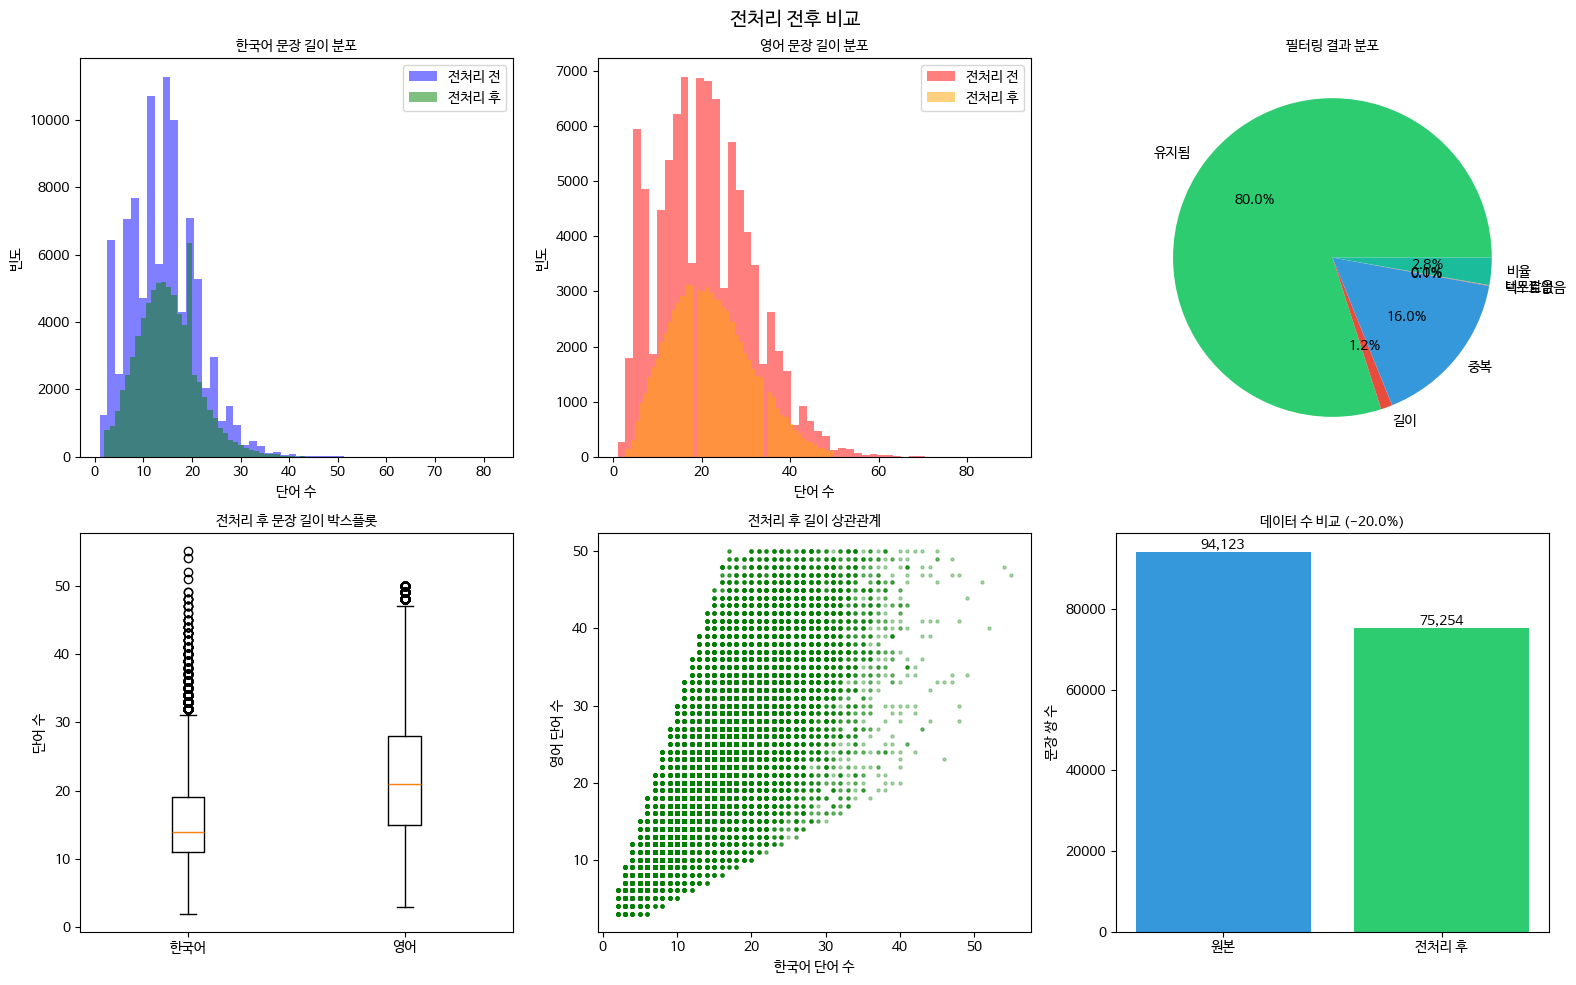


📊 전처리 후 통계:
  한국어 - 평균: 14.9단어, 중앙값: 14.0단어
  영어   - 평균: 21.9단어, 중앙값: 21.0단어

📁 전처리 결과 저장 완료!
한국어: /content/work/dataset/preprocessed.ko
  - 문장 수: 75,254개, 크기: 11.15 MB
영어: /content/work/dataset/preprocessed.en
  - 문장 수: 75,254개, 크기: 9.60 MB
통계: /content/work/dataset/preprocess_stats.csv
리포트: /content/work/dataset/preprocess_report.txt


In [63]:
# 전처리 결과 검토
# answers(영어), questions(한국어) 순서로 전달해야 함 (함수 정의에 따름)
eng_filtered, kor_filtered = preprocess_data_v2(answers, questions, show_samples=2, save_dir=dataset_dir)

# **3. 데이터 증강**

In [64]:
!pip install koeda

from koeda import EDA

sentence = "오늘 날씨가 정말 좋네요"
aug = EDA()

print(aug(sentence))

날씨 오늘가 정말 좋네요


In [65]:
from sklearn.model_selection import train_test_split
from koeda import EDA
import random

# KoEDAugmenter 클래스
class KoEDAugmenter:
    """KoEDA 라이브러리 기반 한국어 데이터 증강 클래스"""

    def __init__(self):
        print("\nKoEDA 초기화 중...")
        self.eda = EDA(
            morpheme_analyzer="Okt",
            alpha_sr=0.1,
            alpha_ri=0.1,
            alpha_rs=0.1,
            prob_rd=0.1
        )
        print("✅ KoEDA 초기화 완료!\n")

    def augment(
        self,
        sentence: str,
        alpha_sr: float = 0.1,
        alpha_ri: float = 0.1,
        alpha_rs: float = 0.1,
        p_rd: float = 0.1,
        num_aug: int = 1
    ) -> list:
        if len(sentence.split()) <= 1:
            return []

        try:
            self.eda.alpha_sr = alpha_sr
            self.eda.alpha_ri = alpha_ri
            self.eda.alpha_rs = alpha_rs
            self.eda.prob_rd = p_rd

            augmented = []
            for _ in range(num_aug):
                result = self.eda(sentence)
                if isinstance(result, str):
                    augmented.append(result)
                elif isinstance(result, list):
                    augmented.extend(result)

            augmented = list(set(augmented))
            augmented = [s for s in augmented if s != sentence and len(s.strip()) > 0]

            return augmented

        except Exception:
            return []


# ========================================
# 전처리된 데이터 로드
# ========================================
KOR_PATH = os.path.join(dataset_dir, 'preprocessed.ko')
ENG_PATH = os.path.join(dataset_dir, 'preprocessed.en')

# 전처리된 데이터 로드
if 'load_data' not in globals():
    def load_data(kor_path, eng_path):
        with open(kor_path, 'r', encoding='utf-8') as f:
            kor_lines = [line.strip() for line in f.readlines()]
        with open(eng_path, 'r', encoding='utf-8') as f:
            eng_lines = [line.strip() for line in f.readlines()]
        return kor_lines, eng_lines

kor_sentences, eng_sentences = load_data(KOR_PATH, ENG_PATH)

print(f"전처리된 데이터: {len(kor_sentences):,}개")

# 데이터 분할 (80/10/10)
train_ko, temp_ko, train_en, temp_en = train_test_split(
    kor_sentences, eng_sentences, test_size=0.2, random_state=SEED
)
val_ko, test_ko, val_en, test_en = train_test_split(
    temp_ko, temp_en, test_size=0.5, random_state=SEED
)

print("\n" + "=" * 60)
print("데이터 분할 완료:")
print(f"Train: {len(train_ko):,}개")
print(f"Val  : {len(val_ko):,}개")
print(f"Test : {len(test_ko):,}개")
print("=" * 60)

# ========================================
# 🔹 목표: 원본의 10% 증강
# 원본: ~60,203개 → 증강: ~6,020개 → 총합: ~66,223개
# ========================================
AUGMENT_RATIO = 0.1  # 10% 증강
AUGMENT_NEEDED = int(len(train_ko) * AUGMENT_RATIO)
TARGET_TOTAL = len(train_ko) + AUGMENT_NEEDED

print(f"\n원본 Train: {len(train_ko):,}개")
print(f"증강 비율: {AUGMENT_RATIO:.0%}")
print(f"증강 필요: {AUGMENT_NEEDED:,}개")
print(f"목표 총합: {TARGET_TOTAL:,}개")

# 증강할 문장 샘플링
train_ko_to_aug, _, train_en_to_aug, _ = train_test_split(
    train_ko, train_en,
    train_size=AUGMENT_NEEDED,
    random_state=SEED
)

print(f"증강 대상: {len(train_ko_to_aug):,}개")
print("=" * 60)

# ========================================
# KoEDA 증강 실행 (한국어만)
# ========================================
augmenter = KoEDAugmenter()

aug_ko = []  # 증강된 한국어
aug_en = []  # 대응하는 영어 (원본 그대로)
aug_ko_source = [] # 원본 한국어 (샘플 출력용)

print("\n증강 진행 중...")
for ko, en in tqdm(zip(train_ko_to_aug, train_en_to_aug), total=len(train_ko_to_aug)):
    # 한국어 증강
    augmented = augmenter.augment(
        ko,
        alpha_sr=0.1,
        alpha_ri=0.1,
        alpha_rs=0.1,
        p_rd=0.1,
        num_aug=1
    )

    # 증강 성공 시 추가
    if augmented:
        aug_ko.append(augmented[0])  # 증강된 한국어
        aug_en.append(en)            # 영어는 그대로
        aug_ko_source.append(ko)     # 원본도 함께 저장 (인덱스 정렬을 위해)

print(f"\n증강 결과: {len(aug_ko):,}개 생성")

# ========================================
# 원본 + 증강 합치기
# ========================================
final_train_ko = list(train_ko) + aug_ko
final_train_en = list(train_en) + aug_en

# 셔플
combined = list(zip(final_train_ko, final_train_en))
random.shuffle(combined)
train_ko, train_en = zip(*combined)
train_ko, train_en = list(train_ko), list(train_en)

print("\n" + "=" * 60)
print("최종 데이터셋 구성:")
print(f"Train: {len(train_ko):,}개 (원본 + 증강 {len(aug_ko):,}개)")
print(f"Val  : {len(val_ko):,}개")
print(f"Test : {len(test_ko):,}개")
print(f"총합 : {len(train_ko) + len(val_ko) + len(test_ko):,}개")
print("=" * 60)

# ========================================
# 🔹 증강 데이터 저장
# ========================================
ko_save_path = os.path.join(dataset_dir, 'augmented_train.ko')
en_save_path = os.path.join(dataset_dir, 'augmented_train.en')

with open(ko_save_path, 'w', encoding='utf-8') as f:
    for sent in train_ko:
        f.write(sent + '\n')

with open(en_save_path, 'w', encoding='utf-8') as f:
    for sent in train_en:
        f.write(sent + '\n')

# 파일 크기 확인
ko_size = os.path.getsize(ko_save_path) / (1024 * 1024)
en_size = os.path.getsize(en_save_path) / (1024 * 1024)

print("\n" + "=" * 60)
print("📁 증강 데이터 저장 완료!")
print("=" * 60)
print(f"한국어: {ko_save_path}")
print(f"  - 문장 수: {len(train_ko):,}개")
print(f"  - 파일 크기: {ko_size:.2f} MB")
print(f"영어: {en_save_path}")
print(f"  - 문장 수: {len(train_en):,}개")
print(f"  - 파일 크기: {en_size:.2f} MB")
print("=" * 60)

# 증강 샘플 확인 (수정됨)
print("\n📋 증강 샘플 (3개)")
print("-" * 60)
# aug_ko에 있는 인덱스를 기준으로 샘플링해야 함
if len(aug_ko) > 0:
    sample_indices = random.sample(range(len(aug_ko)), min(3, len(aug_ko)))
    for i, idx in enumerate(sample_indices, 1):
        print(f"[{i}] 원본 🇰🇷: {aug_ko_source[idx]}") # 저장해둔 원본 사용
        print(f"    증강 🇰🇷: {aug_ko[idx]}")
        print(f"    영어 🇺🇸: {aug_en[idx]}")
        print()
else:
    print("증강된 데이터가 없습니다.")
print("-" * 60)

총 문장 쌍: 75,254
전처리된 데이터: 75,254개

데이터 분할 완료:
Train: 60,203개
Val  : 7,525개
Test : 7,526개

원본 Train: 60,203개
증강 비율: 10%
증강 필요: 6,020개
목표 총합: 66,223개
증강 대상: 6,020개

KoEDA 초기화 중...
✅ KoEDA 초기화 완료!


증강 진행 중...


100%|██████████| 6020/6020 [01:46<00:00, 56.68it/s]



증강 결과: 5,761개 생성

최종 데이터셋 구성:
Train: 65,964개 (원본 + 증강 5,761개)
Val  : 7,525개
Test : 7,526개
총합 : 81,015개

📁 증강 데이터 저장 완료!
한국어: /content/work/dataset/augmented_train.ko
  - 문장 수: 65,964개
  - 파일 크기: 9.78 MB
영어: /content/work/dataset/augmented_train.en
  - 문장 수: 65,964개
  - 파일 크기: 8.42 MB

📋 증강 샘플 (3개)
------------------------------------------------------------
[1] 원본 🇰🇷: 아프가니스탄 중부 가즈니주에서 두번째 한국인 인질 피살자로 추정되는 시신이 발견됐다고 31일 아프간 내무부 관리가 밝혔다.
    증강 🇰🇷: 아프가니스탄 중부 귓바퀴 가즈니주에서 두번째 한국인 인질 순리 피살자로 추정되는 시신이 발견됐다고 31일 아프간 내무부 관리가 밝혔다.
    영어 🇺🇸: the body of a second south korean hostage killed was found tuesday in the chahor devor area of ghazni province in central afghanistan, according to an afghan interior ministry official.

[2] 원본 🇰🇷: 국제 사회는 겉으로 합법적이던 불법적이던 상관없이 소위 불량 국가들의 모든 경제활동을 중단시켜야 한다고 미국의 한 고위 관리가 뉴욕에서 말했다.
    증강 🇰🇷: 국제 사회는 겉으로 합법적이던 불법적이던 상관없이 소위 불량 국가들의 모든 경제활동을 중단시켜야 미국의 한 고위 관리가 뉴욕에서 했다.
    영어 🇺🇸: a ranking u.s. official said in new york on monday that the international community 

# 4. 모델 설정 (Configuration)
모델 학습에 필요한 모든 설정을 정의
- 데이터 경로
- 배치 크기
- 에폭 수
- 모델 크기

In [96]:
# data path
DATA_DIR = 'content/work/dataset'
ENG_TRAIN_PATH = f'{DATA_DIR}/augmented_train.en'
KOR_TRAIN_PATH = f'{DATA_DIR}/augmented_train.ko'

# 저장 경로
MODEL_DIR = 'content/work/models'
TOKENIZER_DIR = 'content/work/tokenizers'
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TOKENIZER_DIR, exist_ok=True)

MODEL_SAVE_PATH = f'{MODEL_DIR}/transformer_eng_kor.pt'
ENG_TOKENIZER_PREFIX = f'{TOKENIZER_DIR}/kor_eng'
KOR_TOKENIZER_PREFIX = f'{TOKENIZER_DIR}/eng_kor'

#data configs
DATA_CONFIG = EasyDict({
    'train_ratio': 0.8,
    'val_ratio': 0.1,
    'test_ratio': 0.1,
    'alpha_sr': 0.1,
    'max_length': 50,     # 최대 시퀀스 길이
    'vocab_size_eng': 8000,
    'vocab_size_kor': 8000,
    'batch_size': 128,     # 배치 크기 (메모리에 맞게 조정)
    'num_workers': 0,     # DataLoader 워커 수
})

#Model config
MODEL_CONFIG = EasyDict({
    'emb_dim': 256,       # 임베딩 차원
    'ffn_dim': 1024,      # Feed-Forward 차원
    'num_heads': 8,       # 어텐션 헤드 수
    'encoder_layers': 6,  # 인코더 레이어 수
    'decoder_layers': 6,  # 디코더 레이어 수
    'dropout': 0.1,
    'attention_dropout': 0.1,
    'max_position_embeddings': 100,
})

# training config
TRAIN_CONFIG = EasyDict({
    'num_epochs': 30,     # 에폭 수
    'learning_rate': 0.0005,
    'betas': (0.9, 0.98),
    'eps': 1e-9,
    'weight_decay': 0.01,
    'clip': 1.0,          # 그래디언트 클리핑
    'label_smoothing': 0.1,
    'patience': 3,        # Early Stopping
    'min_delta': 1e-4,
})

print("설정 완료!")
print(f"\n디바이스: {device}")
print(f"배치 크기: {DATA_CONFIG.batch_size}")
print(f"에폭 수: {TRAIN_CONFIG.num_epochs}")
print(f"모델 크기: {MODEL_CONFIG.emb_dim}")

설정 완료!

디바이스: cuda
배치 크기: 128
에폭 수: 30
모델 크기: 256



# 5.토크나이저 (SentencePiece) 정의

SentencePiece 기반 토크나이저를 정의합니다.

In [97]:
def train_sentencepiece(data: List[str], model_prefix: str, vocab_size: int = 8000):
    """
    SentencePiece 모델을 학습합니다.
    """
    print("=" * 60)
    print(f"SentencePiece 학습: {model_prefix} (Vocab: {vocab_size})")

    corpus_path = f'{model_prefix}_corpus.txt'
    with open(corpus_path, 'w', encoding='utf-8') as f:
        for line in data:
            f.write(f'{line}\n')

    train_args = (
        f'--input={corpus_path} '
        f'--model_prefix={model_prefix} '
        f'--vocab_size={vocab_size} '
        f'--model_type=unigram '
        f'--pad_id=0 --unk_id=1 --bos_id=2 --eos_id=3 '
        f'--character_coverage=1.0'
    )

    spm.SentencePieceTrainer.Train(train_args)

    if os.path.exists(corpus_path):
        os.remove(corpus_path)

    print(f"완료: {model_prefix}.model")
    print("=" * 60)
    return f"{model_prefix}.model"


class SentencePieceVocab:
    """
    SentencePiece 기반 어휘 사전 클래스
    """

    def __init__(self, model_path: str):
        self.sp = spm.SentencePieceProcessor()
        self.sp.Load(model_path)

        self.PAD_ID = 0
        self.UNK_ID = 1
        self.BOS_ID = 2
        self.EOS_ID = 3

        self.stoi = {'<pad>': 0, '<unk>': 1, '<s>': 2, '</s>': 3}
        self.itos = [self.sp.IdToPiece(i) for i in range(self.sp.GetPieceSize())]

    def encode(self, text: str) -> List[int]:
        return self.sp.EncodeAsIds(text)

    def decode(self, ids: List[int]) -> str:
        filtered_ids = [i for i in ids if i not in [self.PAD_ID, self.BOS_ID, self.EOS_ID]]
        return self.sp.DecodeIds(filtered_ids)

    def __len__(self) -> int:
        return self.sp.GetPieceSize()


print("토크나이저 클래스 정의 완료!")

토크나이저 클래스 정의 완료!



# 6. PyTorch Dataset & DataLoader

번역 작업을 위한 Dataset과 DataLoader를 정의합니다.

In [98]:
class TranslationDataset(Dataset):
    """
    번역 작업을 위한 PyTorch Dataset
    """

    def __init__(self, src_list, trg_list, vocab_src, vocab_trg, max_length=60):
        self.src_list = src_list
        self.trg_list = trg_list
        self.vocab_src = vocab_src
        self.vocab_trg = vocab_trg
        self.max_length = max_length

    def __len__(self):
        return len(self.src_list)

    def __getitem__(self, idx):
        src_text = self.src_list[idx]
        trg_text = self.trg_list[idx]

        src_encoded = [self.vocab_src.BOS_ID] + self.vocab_src.encode(src_text) + [self.vocab_src.EOS_ID]

        trg_encoded = [self.vocab_trg.BOS_ID] + self.vocab_trg.encode(trg_text) + [self.vocab_trg.EOS_ID]

        src_encoded = src_encoded[:self.max_length]
        trg_encoded = trg_encoded[:self.max_length]

        return {
            'SRC': torch.tensor(src_encoded, dtype=torch.long),
            'TRG': torch.tensor(trg_encoded, dtype=torch.long),
            'SRC_TEXT': src_text,
            'TRG_TEXT': trg_text
        }


def collate_fn(batch, pad_idx=0):
    """
    배치 내 샘플들을 동일한 길이로 패딩합니다.
    """
    src_batch = [item['SRC'] for item in batch]
    trg_batch = [item['TRG'] for item in batch]
    src_text = [item['SRC_TEXT'] for item in batch]
    trg_text = [item['TRG_TEXT'] for item in batch]

    src_padded = pad_sequence(src_batch, batch_first=True, padding_value=pad_idx)
    trg_padded = pad_sequence(trg_batch, batch_first=True, padding_value=pad_idx)

    return {
        'SRC': src_padded,
        'TRG': trg_padded,
        'SRC_TEXT': src_text,
        'TRG_TEXT': trg_text
    }


print("Dataset 및 DataLoader 함수 정의 완료!")

Dataset 및 DataLoader 함수 정의 완료!



# 7. 모델 주요 모듈 설계

Multi-Head Attention, Feed-Forward, Positional Embedding 등을 정의

In [99]:
class MultiHeadAttention(nn.Module):
    """
    멀티 헤드 어텐션 (Multi-Head Attention)
    """

    def __init__(self, emb_dim, num_heads, dropout=0.0, bias=False,
                 encoder_decoder_attention=False, causal=False):
        super().__init__()

        self.emb_dim = emb_dim
        self.num_heads = num_heads
        self.dropout = dropout
        self.head_dim = emb_dim // num_heads

        assert self.head_dim * num_heads == self.emb_dim

        self.encoder_decoder_attention = encoder_decoder_attention
        self.causal = causal

        self.q_proj = nn.Linear(emb_dim, emb_dim, bias=bias)
        self.k_proj = nn.Linear(emb_dim, emb_dim, bias=bias)
        self.v_proj = nn.Linear(emb_dim, emb_dim, bias=bias)
        self.out_proj = nn.Linear(emb_dim, emb_dim, bias=bias)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_heads, self.head_dim)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, query, key, attention_mask=None):
        q = self.q_proj(query)

        if self.encoder_decoder_attention:
            k = self.k_proj(key)
            v = self.v_proj(key)
        else:
            k = self.k_proj(query)
            v = self.v_proj(query)

        q = self.transpose_for_scores(q)
        k = self.transpose_for_scores(k)
        v = self.transpose_for_scores(v)

        attn_weights = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(self.head_dim)

        if attention_mask is not None:
            if self.causal:
                attn_weights = attn_weights.masked_fill(
                    attention_mask.unsqueeze(0).unsqueeze(1), float("-inf")
                )
            else:
                attn_weights = attn_weights.masked_fill(
                    attention_mask.unsqueeze(1).unsqueeze(2), float("-inf")
                )

        attn_weights = F.softmax(attn_weights, dim=-1)
        attn_probs = F.dropout(attn_weights, p=self.dropout, training=self.training)
        attn_output = torch.matmul(attn_probs, v)

        attn_output = attn_output.permute(0, 2, 1, 3).contiguous()
        concat_shape = attn_output.size()[:-2] + (self.emb_dim,)
        attn_output = attn_output.view(*concat_shape)
        attn_output = self.out_proj(attn_output)

        return attn_output, attn_weights


class PositionWiseFeedForward(nn.Module):
    """
    위치별 피드포워드 네트워크
    """

    def __init__(self, emb_dim, d_ff, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Linear(emb_dim, d_ff)
        self.w_2 = nn.Linear(d_ff, emb_dim)
        self.dropout = dropout
        self.activation = nn.ReLU()

    def forward(self, x):
        # residual = x
        x = self.activation(self.w_1(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.w_2(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        return x #+ residual


class SinusoidalPositionalEmbedding(nn.Embedding):
    """
    사인/코사인 위치 임베딩
    """

    def __init__(self, num_positions, embedding_dim, padding_idx=None):
        super().__init__(num_positions, embedding_dim)
        self._init_weight(self.weight)

    @staticmethod
    def _init_weight(out):
        n_pos, embed_dim = out.shape
        position_enc = torch.zeros(n_pos, embed_dim)

        for pos in range(n_pos):
            for i in range(0, embed_dim, 2):
                position_enc[pos, i] = math.sin(pos / (10000 ** (i / embed_dim)))
                if i + 1 < embed_dim:
                    position_enc[pos, i + 1] = math.cos(pos / (10000 ** ((i + 1) / embed_dim)))

        out.data.copy_(position_enc)
        out.requires_grad = False

    @torch.no_grad()
    def forward(self, input_ids):
        bsz, seq_len = input_ids.shape[:2]
        positions = torch.arange(seq_len, dtype=torch.long, device=self.weight.device)
        return super().forward(positions)


# 8. Transformer 전체 모델

Encoder, Decoder, 그리고 전체 Transformer 모델을 정의합니다.

In [100]:
class EncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.self_attn = MultiHeadAttention(config.emb_dim, config.num_heads, config.attention_dropout)
        self.ffn = PositionWiseFeedForward(config.emb_dim, config.ffn_dim, config.dropout)
        self.norm1 = nn.LayerNorm(config.emb_dim)
        self.norm2 = nn.LayerNorm(config.emb_dim)
        self.dropout = config.dropout

    def forward(self, x, attention_mask=None):
        norm_x = self.norm1(x)
        attn_output, attn_weights = self.self_attn(norm_x, norm_x, attention_mask)
        x = x + F.dropout(attn_output, p=self.dropout, training=self.training)

        norm_x = self.norm2(x)
        ffn_output = self.ffn(norm_x)
        x = x + F.dropout(ffn_output, p=self.dropout, training=self.training)

        return x, attn_weights


class Encoder(nn.Module):
    def __init__(self, config, embed_tokens):
        super().__init__()
        self.padding_idx = embed_tokens.padding_idx
        self.embed_tokens = embed_tokens
        self.embed_positions = SinusoidalPositionalEmbedding(
            config.max_position_embeddings, config.emb_dim, self.padding_idx
        )
        self.layers = nn.ModuleList([EncoderLayer(config) for _ in range(config.encoder_layers)])
        self.dropout = nn.Dropout(config.dropout)
        self.final_norm = nn.LayerNorm(config.emb_dim)

    def forward(self, input_ids, attention_mask=None):
        # Embedding Scaling 추가: sqrt(d_model)을 곱해줌
        inputs_embeds = self.embed_tokens(input_ids) * math.sqrt(self.embed_tokens.embedding_dim)
        embed_pos = self.embed_positions(input_ids)
        x = self.dropout(inputs_embeds + embed_pos)

        attention_scores = []
        for layer in self.layers:
            x, attn = layer(x, attention_mask)
            attention_scores.append(attn)

        x = self.final_norm(x)
        return x, attention_scores


class DecoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.self_attn = MultiHeadAttention(config.emb_dim, config.num_heads, config.attention_dropout, causal=True)
        self.cross_attn = MultiHeadAttention(config.emb_dim, config.num_heads, config.attention_dropout, encoder_decoder_attention=True)
        self.ffn = PositionWiseFeedForward(config.emb_dim, config.ffn_dim, config.dropout)
        self.norm1 = nn.LayerNorm(config.emb_dim)
        self.norm2 = nn.LayerNorm(config.emb_dim)
        self.norm3 = nn.LayerNorm(config.emb_dim)
        self.dropout = config.dropout

    def forward(self, x, encoder_output, encoder_attention_mask=None, decoder_causal_mask=None):
        norm_x = self.norm1(x)
        self_attn_output, self_attn_weights = self.self_attn(norm_x, norm_x, decoder_causal_mask)
        x = x + F.dropout(self_attn_output, p=self.dropout, training=self.training)

        norm_x = self.norm2(x)
        cross_attn_output, cross_attn_weights = self.cross_attn(norm_x, encoder_output, encoder_attention_mask)
        x = x + F.dropout(cross_attn_output, p=self.dropout, training=self.training)

        norm_x = self.norm3(x)
        ffn_output = self.ffn(norm_x)
        x = x + F.dropout(ffn_output, p=self.dropout, training=self.training)

        return x, (self_attn_weights, cross_attn_weights)


class Decoder(nn.Module):
    def __init__(self, config, embed_tokens):
        super().__init__()
        self.padding_idx = embed_tokens.padding_idx
        self.embed_tokens = embed_tokens
        self.embed_positions = SinusoidalPositionalEmbedding(
            config.max_position_embeddings, config.emb_dim, self.padding_idx
        )
        self.layers = nn.ModuleList([DecoderLayer(config) for _ in range(config.decoder_layers)])
        self.dropout = nn.Dropout(config.dropout)
        self.final_norm = nn.LayerNorm(config.emb_dim)

    def forward(self, input_ids, encoder_output, encoder_attention_mask=None, decoder_causal_mask=None):
        # Embedding Scaling 추가: sqrt(d_model)을 곱해줌
        inputs_embeds = self.embed_tokens(input_ids) * math.sqrt(self.embed_tokens.embedding_dim)
        embed_pos = self.embed_positions(input_ids)
        x = self.dropout(inputs_embeds + embed_pos)

        attention_scores = []
        for layer in self.layers:
            x, attn = layer(x, encoder_output, encoder_attention_mask, decoder_causal_mask)
            attention_scores.append(attn)

        x = self.final_norm(x)
        return x, attention_scores


class Transformer(nn.Module):
    """
    Transformer 모델
    """

    def __init__(self, vocab_src, vocab_trg, config):
        super().__init__()
        self.vocab_src = vocab_src
        self.vocab_trg = vocab_trg
        self.config = config

        self.enc_embedding = nn.Embedding(len(vocab_src), config.emb_dim, padding_idx=vocab_src.PAD_ID)
        self.dec_embedding = nn.Embedding(len(vocab_trg), config.emb_dim, padding_idx=vocab_trg.PAD_ID)

        self.encoder = Encoder(config, self.enc_embedding)
        self.decoder = Decoder(config, self.dec_embedding)
        self.prediction_head = nn.Linear(config.emb_dim, len(vocab_trg))

        self._init_weights()

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def generate_mask(self, src, trg):
        enc_attention_mask = (src == self.vocab_src.PAD_ID)
        tgt_len = trg.size(1)
        dec_causal_mask = torch.triu(
            torch.ones(tgt_len, tgt_len, dtype=torch.bool, device=trg.device), diagonal=1
        )
        return enc_attention_mask, dec_causal_mask

    def forward(self, src, trg):
        enc_attention_mask, dec_causal_mask = self.generate_mask(src, trg)
        encoder_output, encoder_attn = self.encoder(src, enc_attention_mask)
        decoder_output, decoder_attn = self.decoder(trg, encoder_output, enc_attention_mask, dec_causal_mask)
        logits = self.prediction_head(decoder_output)
        return logits, encoder_attn, decoder_attn

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

# 9. 학습 및 평가 유틸리티

손실 함수, 학습 함수, 평가 함수 등을 정의

In [101]:
class LabelSmoothingLoss(nn.Module):
    """
    Label Smoothing을 적용한 Cross Entropy Loss
    """

    def __init__(self, classes, smoothing=0.1, dim=-1, ignore_index=None):
        super().__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim
        self.ignore_index = ignore_index

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)

        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 2))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)

            if self.ignore_index is not None:
                true_dist[:, self.ignore_index] = 0
                mask = torch.nonzero(target.data == self.ignore_index)
                if mask.dim() > 0:
                    true_dist.index_fill_(0, mask.squeeze(), 0.0)

        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))


def train_epoch(model, iterator, optimizer, criterion, clip, device):
    """
    한 에폭 동안 모델을 학습합니다.
    """
    model.train()
    epoch_loss = 0

    # progress_bar = tqdm(iterator, desc="  Training", leave=False)
    batches = iterator

    for batch in batches :
        src = batch['SRC'].to(device)
        trg = batch['TRG'].to(device)

        optimizer.zero_grad()
        output, _, _ = model(src, trg[:, :-1])

        output_dim = output.shape[-1]
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:, 1:].contiguous().view(-1)

        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()
        # progress_bar.set_postfix(loss=f"{loss.item():.3f}")

    return epoch_loss / len(iterator)


def evaluate(model, iterator, criterion, device):
    """
    모델을 평가
    """
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for batch in iterator:
            src = batch['SRC'].to(device)
            trg = batch['TRG'].to(device)

            output, _, _ = model(src, trg[:, :-1])

            output_dim = output.shape[-1]
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:, 1:].contiguous().view(-1)

            loss = criterion(output, trg)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

def translate_sentence(sentence, model, vocab_src, vocab_trg, device,
                       max_len=60, repetition_penalty=1.2, no_repeat_ngram=3):
    """
    하나의 문장을 번역 (Repetition Penalty 적용)

    Args:
        repetition_penalty: 반복 토큰에 대한 페널티 (1.0=없음, 1.2~1.5 권장)
        no_repeat_ngram: 반복 금지할 n-gram 크기 (3이면 3-gram 반복 금지)
    """
    model.eval()

    if isinstance(sentence, str):
        tokens = [vocab_src.BOS_ID] + vocab_src.encode(sentence) + [vocab_src.EOS_ID]
    else:
        tokens = [vocab_src.BOS_ID] + vocab_src.encode(sentence) + [vocab_src.EOS_ID]

    src_tensor = torch.LongTensor(tokens).unsqueeze(0).to(device)
    src_mask = (src_tensor == vocab_src.PAD_ID)

    with torch.no_grad():
        encoder_output, _ = model.encoder(src_tensor, src_mask)
        trg_indexes = [vocab_trg.BOS_ID]

        for i in range(max_len):
            trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
            tgt_len = trg_tensor.size(1)
            dec_causal_mask = torch.triu(
                torch.ones(tgt_len, tgt_len, dtype=torch.bool, device=device), diagonal=1
            )

            decoder_output, decoder_attn = model.decoder(
                trg_tensor, encoder_output, src_mask, dec_causal_mask
            )

            # 마지막 토큰의 logits 가져오기
            logits = decoder_output[:, -1, :]  # [1, vocab_size]

            # ========================================
            # 1. Repetition Penalty 적용
            # ========================================
            if repetition_penalty != 1.0:
                for prev_token in set(trg_indexes):
                    if logits[0, prev_token] > 0:
                        logits[0, prev_token] /= repetition_penalty
                    else:
                        logits[0, prev_token] *= repetition_penalty

            # ========================================
            # 2. No Repeat N-gram 적용
            # ========================================
            if no_repeat_ngram > 0 and len(trg_indexes) >= no_repeat_ngram:
                # 현재까지의 (n-1)-gram
                ngram_prefix = tuple(trg_indexes[-(no_repeat_ngram-1):])

                # 이전에 같은 prefix 뒤에 나왔던 토큰들 찾기
                for j in range(len(trg_indexes) - no_repeat_ngram + 1):
                    prev_ngram = tuple(trg_indexes[j:j + no_repeat_ngram - 1])
                    if prev_ngram == ngram_prefix:
                        # 해당 n-gram 다음에 나온 토큰 금지
                        banned_token = trg_indexes[j + no_repeat_ngram - 1]
                        logits[0, banned_token] = float('-inf')

            # ========================================
            # 3. 다음 토큰 선택
            # ========================================
            pred_token = logits.argmax(dim=-1).item()
            trg_indexes.append(pred_token)

            if pred_token == vocab_trg.EOS_ID:
                break

    translated_tokens = [vocab_trg.itos[i] for i in trg_indexes]
    attention = decoder_attn[-1][1].squeeze(0).cpu().detach().numpy()

    return translated_tokens[1:], attention


# 10. 토크나이저 학습/로드
SentencePiece 토크나이저를 학습하거나 기존 모델을 로드합니다.

In [102]:
# 토크나이저 수정
# ============================================
# Section 10: 토크나이저 학습/로드 (수정됨)
# ============================================

# 토크나이저 학습 (또는 로드)
kor_model_path = f"{KOR_TOKENIZER_PREFIX}.model"  # 한국어 (소스)
eng_model_path = f"{ENG_TOKENIZER_PREFIX}.model"  # 영어 (타겟)

if os.path.exists(kor_model_path) and os.path.exists(eng_model_path):
    print("기존 토크나이저 로드 중...")
    vocab_src = SentencePieceVocab(kor_model_path)  # 소스 = 한국어
    vocab_trg = SentencePieceVocab(eng_model_path)  # 타겟 = 영어
    print(f"한국어 (소스) Vocab: {len(vocab_src):,} tokens")
    print(f"영어 (타겟) Vocab: {len(vocab_trg):,} tokens")
else:
    print("토크나이저 학습 중...")

    # ✅ 올바른 변수 매핑 (수정됨: train_q -> train_ko)
    all_kor = train_ko + val_ko + test_ko  # 한국어 (소스)
    all_eng = train_en + val_en + test_en  # 영어 (타겟)

    # 한국어 토크나이저 학습 (소스)
    train_sentencepiece(all_kor, KOR_TOKENIZER_PREFIX, DATA_CONFIG.vocab_size_kor)
    vocab_src = SentencePieceVocab(kor_model_path)

    # 영어 토크나이저 학습 (타겟)
    train_sentencepiece(all_eng, ENG_TOKENIZER_PREFIX, DATA_CONFIG.vocab_size_eng)
    vocab_trg = SentencePieceVocab(eng_model_path)

    print("\n토크나이저 학습 완료!")
    print(f"한국어 (소스) Vocab: {len(vocab_src):,} tokens")
    print(f"영어 (타겟) Vocab: {len(vocab_trg):,} tokens")

기존 토크나이저 로드 중...
한국어 (소스) Vocab: 8,000 tokens
영어 (타겟) Vocab: 8,000 tokens


# 11. DataLoader 생성
PyTorch DataLoader를 생성합니다.

In [103]:
# ============================================
# Section 11: DataLoader 생성 (수정됨)
# ============================================
print("=" * 60)
print("DataLoader 생성")
print(f"  번역 방향: 한국어 → 영어")
print(f"  Train 데이터: {len(train_ko):,}개 (증강됨)")

# Dataset 생성
# src_list = 한국어 (train_ko), trg_list = 영어 (train_en)
train_dataset = TranslationDataset(train_ko, train_en, vocab_src, vocab_trg, DATA_CONFIG.max_length)
val_dataset = TranslationDataset(val_ko, val_en, vocab_src, vocab_trg, DATA_CONFIG.max_length)
test_dataset = TranslationDataset(test_ko, test_en, vocab_src, vocab_trg, DATA_CONFIG.max_length)

# DataLoader 생성
collate_with_pad = lambda batch: collate_fn(batch, pad_idx=vocab_src.PAD_ID)

train_loader = DataLoader(
    train_dataset,
    batch_size=DATA_CONFIG.batch_size,
    shuffle=True,
    collate_fn=collate_with_pad,
    num_workers=0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=DATA_CONFIG.batch_size,
    shuffle=False,
    collate_fn=collate_with_pad,
    num_workers=0
)

test_loader = DataLoader(
    test_dataset,
    batch_size=DATA_CONFIG.batch_size,
    shuffle=False,
    collate_fn=collate_with_pad,
    num_workers=0
)

print(f"  Train Batches: {len(train_loader)}")
print(f"  Val Batches:   {len(val_loader)}")
print(f"  Test Batches:  {len(test_loader)}")
print("DataLoader 생성 완료!")
print("=" * 60)

# ============================================
# 검증: 데이터 샘플 확인
# ============================================
print("\n📌 데이터 검증:")
print(f"train_ko[0] (한국어/소스): {train_ko[0][:50]}...")
print(f"train_en[0] (영어/타겟): {train_en[0][:50]}...")

DataLoader 생성
  번역 방향: 한국어 → 영어
  Train 데이터: 65,964개 (증강됨)
  Train Batches: 516
  Val Batches:   59
  Test Batches:  59
DataLoader 생성 완료!

📌 데이터 검증:
train_ko[0] (한국어/소스): 이란은 지난 몇주간 원심분리기 수백대 노역 를 설치했으며 다음달까지 3000번의 뒤 작업을...
train_en[0] (영어/타겟): iran has installed hundreds of centrifuges within ...


# 12. 모델 초기화
Transformer 모델, 옵티마이저, 손실 함수를 초기화합니다.

In [104]:
print("모델 초기화 (Embedding Scaling 적용됨)")
# 모델 생성
model = Transformer(vocab_src, vocab_trg, MODEL_CONFIG).to(device)

print(f"모델 파라미터 수: {model.count_parameters():,}")
print(f"디바이스: {device}")

# 옵티마이저
optimizer = optim.AdamW(
    model.parameters(),
    lr=TRAIN_CONFIG.learning_rate,
    betas=TRAIN_CONFIG.betas,
    eps=TRAIN_CONFIG.eps,
    weight_decay=TRAIN_CONFIG.weight_decay
)

# 손실 함수
criterion = LabelSmoothingLoss(
    classes=len(vocab_trg),
    smoothing=TRAIN_CONFIG.label_smoothing,
    ignore_index=vocab_trg.PAD_ID
).to(device)

모델 초기화 (Embedding Scaling 적용됨)
모델 파라미터 수: 17,193,792
디바이스: cuda


# 13. 모델 학습
Transformer 모델을 학습

In [105]:
print("학습 시작...")
best_valid_loss = float('inf')
patience_counter = 0
train_losses = []
val_losses = []

for epoch in tqdm(range(TRAIN_CONFIG.num_epochs), desc="Total Epochs"):
    start_time = time.time()

    # 학습
    train_loss = train_epoch(model, train_loader, optimizer, criterion, TRAIN_CONFIG.clip, device)

    # 검증
    val_loss = evaluate(model, val_loader, criterion, device)

    # 시간 측정
    end_time = time.time()
    epoch_mins, epoch_secs = divmod(end_time - start_time, 60)

    # 손실 기록
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # 모델 저장 및 조기 종료
    save_msg = ""
    if val_loss < best_valid_loss - TRAIN_CONFIG.min_delta:
        best_valid_loss = val_loss
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, MODEL_SAVE_PATH)
        save_msg = "Model Saved"
    else:
        patience_counter += 1
        if patience_counter >= TRAIN_CONFIG.patience:
            tqdm.write(f"\nearly stopping at: {TRAIN_CONFIG.patience} epoch w/o improvement ")
            break

    # 로그 출력
    log_msg = (
        f'[Epoch {epoch+1:02d}] '
        f'Train Loss: {train_loss:.4f} | '
        f'Val Loss: {val_loss:.4f} | '
        f'PPL: {np.exp(train_loss):.2f} | '
        f'Time: {int(epoch_mins)}m {int(epoch_secs)}s'
        f'{save_msg}'
    )
    tqdm.write(log_msg)

print("=" * 60)
print("학습 완료")
print(f"Best Val Loss: {best_valid_loss:.4f}")
print("=" * 60)

학습 시작...


Total Epochs:   3%|▎         | 1/30 [02:01<58:44, 121.53s/it]

[Epoch 01] Train Loss: 3.9296 | Val Loss: 3.5880 | PPL: 50.89 | Time: 2m 1sModel Saved


Total Epochs:   7%|▋         | 2/30 [04:02<56:29, 121.05s/it]

[Epoch 02] Train Loss: 3.4494 | Val Loss: 3.3522 | PPL: 31.48 | Time: 2m 0sModel Saved


Total Epochs:  10%|█         | 3/30 [06:02<54:24, 120.91s/it]

[Epoch 03] Train Loss: 3.2410 | Val Loss: 3.2135 | PPL: 25.56 | Time: 2m 0sModel Saved


Total Epochs:  13%|█▎        | 4/30 [08:03<52:22, 120.87s/it]

[Epoch 04] Train Loss: 3.0906 | Val Loss: 3.1208 | PPL: 21.99 | Time: 2m 0sModel Saved


Total Epochs:  17%|█▋        | 5/30 [10:04<50:20, 120.83s/it]

[Epoch 05] Train Loss: 2.9731 | Val Loss: 3.0568 | PPL: 19.55 | Time: 2m 0sModel Saved


Total Epochs:  20%|██        | 6/30 [12:05<48:19, 120.83s/it]

[Epoch 06] Train Loss: 2.8774 | Val Loss: 3.0153 | PPL: 17.77 | Time: 2m 0sModel Saved


Total Epochs:  23%|██▎       | 7/30 [14:06<46:17, 120.76s/it]

[Epoch 07] Train Loss: 2.7961 | Val Loss: 2.9801 | PPL: 16.38 | Time: 2m 0sModel Saved


Total Epochs:  27%|██▋       | 8/30 [16:06<44:16, 120.75s/it]

[Epoch 08] Train Loss: 2.7271 | Val Loss: 2.9603 | PPL: 15.29 | Time: 2m 0sModel Saved


Total Epochs:  30%|███       | 9/30 [18:07<42:14, 120.71s/it]

[Epoch 09] Train Loss: 2.6653 | Val Loss: 2.9462 | PPL: 14.37 | Time: 2m 0sModel Saved


Total Epochs:  33%|███▎      | 10/30 [20:07<40:12, 120.62s/it]

[Epoch 10] Train Loss: 2.6111 | Val Loss: 2.9367 | PPL: 13.61 | Time: 2m 0sModel Saved


Total Epochs:  37%|███▋      | 11/30 [22:08<38:12, 120.64s/it]

[Epoch 11] Train Loss: 2.5615 | Val Loss: 2.9310 | PPL: 12.95 | Time: 2m 0sModel Saved


Total Epochs:  40%|████      | 12/30 [24:08<36:10, 120.60s/it]

[Epoch 12] Train Loss: 2.5179 | Val Loss: 2.9245 | PPL: 12.40 | Time: 1m 59sModel Saved


Total Epochs:  43%|████▎     | 13/30 [26:09<34:10, 120.61s/it]

[Epoch 13] Train Loss: 2.4771 | Val Loss: 2.9234 | PPL: 11.91 | Time: 2m 0sModel Saved


Total Epochs:  47%|████▋     | 14/30 [28:09<32:06, 120.44s/it]

[Epoch 14] Train Loss: 2.4401 | Val Loss: 2.9261 | PPL: 11.47 | Time: 2m 0s


Total Epochs:  50%|█████     | 15/30 [30:09<30:04, 120.31s/it]

[Epoch 15] Train Loss: 2.4056 | Val Loss: 2.9286 | PPL: 11.09 | Time: 2m 0s


Total Epochs:  50%|█████     | 15/30 [32:09<32:09, 128.64s/it]


early stopping at: 3 epoch w/o improvement 
학습 완료
Best Val Loss: 2.9234


# 14. 학습 곡선 시각화
학습 과정의 손실을 시각화

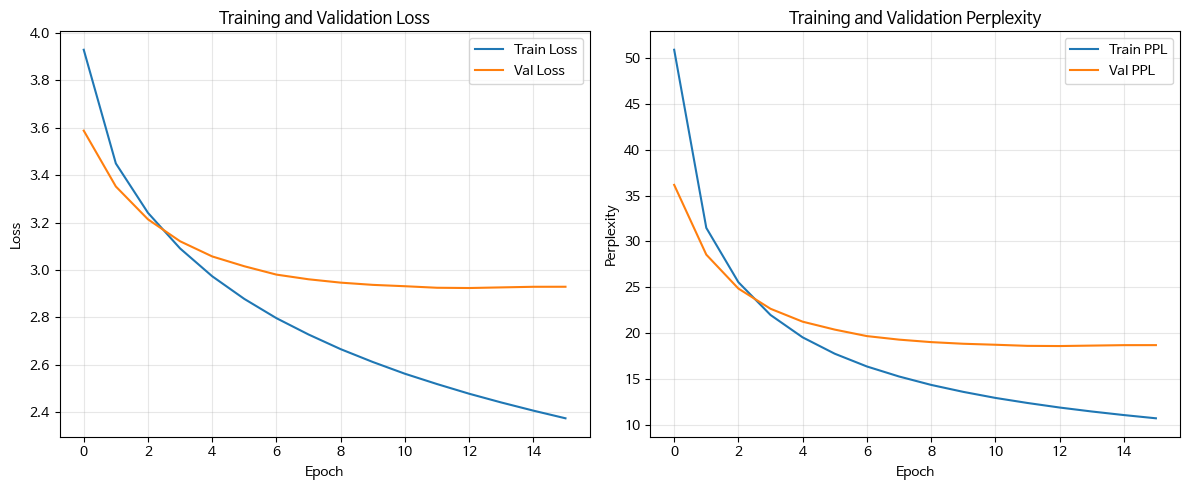

최종 Train Loss: 2.3733
최종 Val Loss: 2.9288
Best Val Loss: 2.9234


In [106]:
plt.figure(figsize=(12, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Perplexity 그래프
plt.subplot(1, 2, 2)
plt.plot([np.exp(l) for l in train_losses], label='Train PPL')
plt.plot([np.exp(l) for l in val_losses], label='Val PPL')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Training and Validation Perplexity')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"최종 Train Loss: {train_losses[-1]:.4f}")
print(f"최종 Val Loss: {val_losses[-1]:.4f}")
print(f"Best Val Loss: {best_valid_loss:.4f}")

# 15. 모델 평가 (Test Set)
테스트 셋에서 모델 성능을 평가

In [107]:
print("테스트 셋 평가")
# 최고 성능 모델 로드
checkpoint = torch.load(MODEL_SAVE_PATH, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

# 테스트 손실 계산
test_loss = evaluate(model, test_loader, criterion, device)
test_ppl = np.exp(test_loss)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Perplexity: {test_ppl:.2f}")
print("=" * 60)

테스트 셋 평가
Test Loss: 2.9186
Test Perplexity: 18.52


# 16. 샘플 번역 테스트
몇 가지 예제 문장을 번역

In [108]:
# 테스트 문장들
test_sentences = [
       "북한이 미사일을 발사했다.",
    "대통령이 기자회견을 열었다.",
    "주식 시장이 하락했다. 미국이 세계경제에 큰 영향을 끼쳤다"
]

model.eval()

for i, sent in enumerate(test_sentences, 1):
    # 전처리
    processed = preprocess_sentence(sent, lang='eng')

    # 번역
    translation, _ = translate_sentence(processed, model, vocab_src, vocab_trg, device)

    # 후처리
    translated_text = "".join([
        t for t in translation
        if t not in ['<eos>', '</s>', '<pad>']
    ]).replace("▁", " ").strip()

    print(f"\n[{i}]")
    print(f"원문: {sent}")
    print(f"번역: {translated_text}")

print("\n" + "=" * 60)


[1]
원문: 북한이 미사일을 발사했다.
번역: “ him `` all end ``le two may `` him in monday world four may time by in i, police japan into just party ( up more those de an they three may sayes in ́s just may still just may this co only may by in)le called i those de two may by i

[2]
원문: 대통령이 기자회견을 열었다.
번역: no our up two," police japan becausees iraq part being there states into monday de co five some people time still time still said said said will’ sore him won of saidle by de)<unk> him him said said him him him still those andn if threet military," said said was

[3]
원문: 주식 시장이 하락했다. 미국이 세계경제에 큰 영향을 끼쳤다
번역: between " himri monday because a by in been more nuclear japan worldduring "leold percent have new first may more thursdayes into war nuclear could by official sunday will more home said said said<unk> of there still still still its thursday those andin i three for “ him still still by in "



# 17. Attention Map

원문 (한국어): Taliban 탈레반, 아프간 남부의 부족단체에서 출발한 조직
정답 (영어): two pakistani intelligence officials say 14 taliban militants and 8 arab foreigners died in the attack.
예측 (영어):  “ him end `` him japan monday not japan first city office percentes her end spokesman have when her its its its end more million reported percent worldi, and her states

Attention Map:


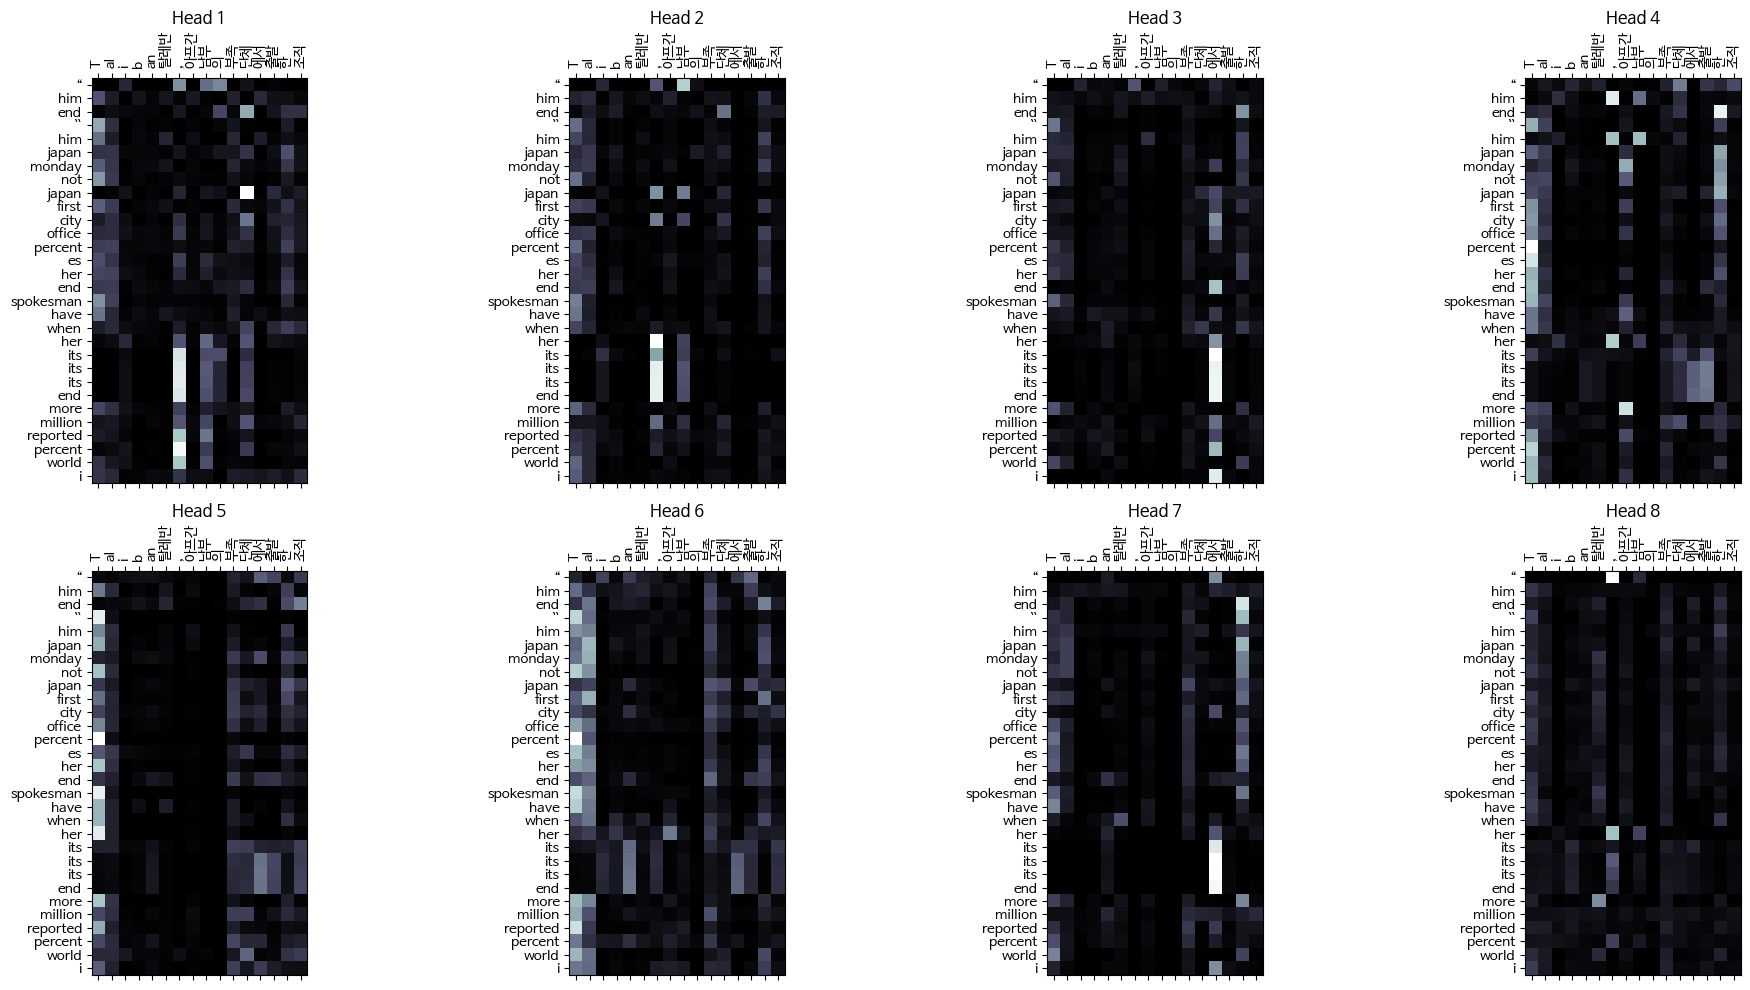

In [110]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker

# 한글 폰트 설정 (Colab)
font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_prop = fm.FontProperties(fname=font_path)

# 전역 폰트 설정 추가
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

def display_attention(src_tokens, trg_tokens, attention, n_heads=8):
    """
    Attention Map 시각화
    """
    # 토큰 정제
    src_clean = [t.replace('▁', '').replace('<unk>', '?') for t in src_tokens]
    trg_clean = [t.replace('▁', '').replace('<unk>', '?') for t in trg_tokens]

    # 길이 제한
    max_len = 30
    if len(src_clean) > max_len:
        src_clean = src_clean[:max_len]
    if len(trg_clean) > max_len:
        trg_clean = trg_clean[:max_len]

    fig = plt.figure(figsize=(20, 10))

    for i in range(min(n_heads, attention.shape[0])):
        ax = fig.add_subplot(2, 4, i + 1)
        attn = attention[i][:len(trg_clean), :len(src_clean)]

        cax = ax.matshow(attn, cmap='bone')
        ax.tick_params(labelsize=10)

        ax.set_xticks(range(len(src_clean)))
        ax.set_xticklabels(src_clean, rotation=90)
        ax.set_yticks(range(len(trg_clean)))
        ax.set_yticklabels(trg_clean)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.set_title(f'Head {i+1}', fontsize=12)

    plt.tight_layout()
    plt.show()


# 샘플 선택
sample_idx = 5
sample_src = test_dataset.src_list[sample_idx]
sample_trg = test_dataset.trg_list[sample_idx]

print(f"원문 (한국어): {sample_src}")
print(f"정답 (영어): {sample_trg}")

# 번역 및 어텐션 추출
translation, attention = translate_sentence(sample_src, model, vocab_src, vocab_trg, device)

print(f"예측 (영어): {''.join([t for t in translation if t not in ['<eos>', '</s>']]).replace('▁', ' ')}")
print("\nAttention Map:")

# 소스 토큰화
src_tokens = [vocab_src.itos[i] for i in vocab_src.encode(sample_src)]

# 시각화
display_attention(src_tokens, translation, attention)

---
#18. 대화형 번역기

직접 문장을 입력해서 번역해볼 수 있습니다.

In [111]:
def interactive_translate():
    """대화형 번역 함수"""
    print("=" * 60)
    print("대화형 번역기")
    print("종료하려면 'quit' 또는 'exit'를 입력하세요")
    print("=" * 60)

    while True:
        kor_input = input("\n한국어 입력: ").strip()

        if kor_input.lower() in ['quit', 'exit', '']:
            print("번역기를 종료합니다.")
            break

        try:
            translation = translate_sentence(kor_input, model, vocab_kor, vocab_eng, device,
                                           use_beam_search=True, beam_size=5)
            print(f"eng 번역: {translation}")
        except Exception as e:
            print(f"오류 발생: {e}")

# 실행
print("interactive_translate() 함수를 호출하여 대화형 번역을 시작하세요!")


interactive_translate() 함수를 호출하여 대화형 번역을 시작하세요!


---
# 19. 모델 저장 및 로드

나중에 사용하기 위해 모델을 저장하고 로드하는 방법

In [112]:
# 모델 저장 (이미 학습 중에 저장됨)
print(f"모델 저장 위치: {MODEL_SAVE_PATH}")

# 모델 로드 예시
def load_trained_model(model_path, vocab_src, vocab_trg, config, device):
    """
    학습된 모델을 로드
    """
    # 모델 생성
    model = Transformer(vocab_src, vocab_trg, config).to(device)

    # 체크포인트 로드
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    model.eval()
    return model


# 사용 예시
# loaded_model = load_trained_model(MODEL_SAVE_PATH, vocab_src, vocab_trg, MODEL_CONFIG, device)
# print("모델 로드 완료!")


모델 저장 위치: content/work/models/transformer_eng_kor.pt


# **20.Blue 등 함수 연산**

In [113]:
!pip install evaluate bert_score rouge_score

import evaluate as hf_evaluate
import itertools

def calculate_comprehensive_metrics(model, iterator, tokenizer_src, tokenizer_trg, device):
    """
    BLEU, METEOR, ROUGE-L, BERTScore를 한 번에 계산
    """
    model.eval()

    # 1. 평가 도구 로드
    metric_bleu = hf_evaluate.load("bleu")
    metric_meteor = hf_evaluate.load("meteor")
    metric_rouge = hf_evaluate.load("rouge")
    metric_bert = hf_evaluate.load("bertscore")

    preds = []
    refs = []

    print("전체 테스트 데이터에 대해 번역 생성 중...")

    # 2. 전체 데이터에 대해 추론 (Batch 단위)
    with torch.no_grad():
        for batch in tqdm(iterator, desc="Generating"):
            src = batch['SRC'].to(device)
            trg = batch['TRG'].to(device)

            # 배치 처리를 위해 간단한 루프
            batch_size = src.shape[0]

            for i in range(batch_size):
                # 소스 문장 (ID -> Text)
                src_ids = src[i].tolist()
                src_text = tokenizer_src.decode(src_ids) # Special token 제거됨

                # 정답 문장 (ID -> Text)
                trg_ids = trg[i].tolist()
                trg_text = tokenizer_trg.decode(trg_ids) # Special token 제거됨

                # 예측 문장 생성
                pred_tokens, _ = translate_sentence(src_text, model, tokenizer_src, tokenizer_trg, device)

                # 토큰 리스트 -> 문장열 결합
                pred_text = "".join(pred_tokens).replace(" ", " ").strip()

                preds.append(pred_text)
                refs.append(trg_text)

    print("\n지표 계산 중... (BERTScore는 시간이 좀 걸립니다)")

    # 3. 지표 계산
    # BLEU (references는 리스트의 리스트여야 함)
    results_bleu = metric_bleu.compute(predictions=preds, references=[[r] for r in refs])

    # METEOR
    results_meteor = metric_meteor.compute(predictions=preds, references=refs)

    # ROUGE
    results_rouge = metric_rouge.compute(predictions=preds, references=refs)

    # BERTScore (English 모델 사용)
    results_bert = metric_bert.compute(predictions=preds, references=refs, lang="en", verbose=True)

    # 4. 결과 출력
    scores = {
        "BLEU": results_bleu['bleu'],
        "METEOR": results_meteor['meteor'],
        "ROUGE-L": results_rouge['rougeL'],
        "BERTScore": sum(results_bert['f1']) / len(results_bert['f1']) # F1 평균
    }

    print("=" * 50)
    print(f"최종 평가 결과:")
    print(f"  BLEU:      {scores['BLEU']:.4f}")
    print(f"  METEOR:    {scores['METEOR']:.4f}")
    print(f"  ROUGE-L:   {scores['ROUGE-L']:.4f}")
    print(f"  BERTScore: {scores['BERTScore']:.4f}")
    print("=" * 50)

    return scores

print("테스트 셋 평가")

# 최고 성능 모델 로드
checkpoint = torch.load(MODEL_SAVE_PATH, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

# test_loader에서 앞쪽 배치 5개만 가져오기 (약 100~300 문장)
small_iterator = itertools.islice(test_loader, 5)

final_scores = calculate_comprehensive_metrics(
    model,
    small_iterator,  # <-- 전체 test_loader 대신 작은 iterator 전달
    vocab_src,
    vocab_trg,
    device
)

# 결과 출력
print("Test Set Final Scores:", final_scores)

테스트 셋 평가


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


전체 테스트 데이터에 대해 번역 생성 중...


Generating: 5it [05:30, 66.08s/it]



지표 계산 중... (BERTScore는 시간이 좀 걸립니다)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/20 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/10 [00:00<?, ?it/s]

done in 21283.92 seconds, 0.03 sentences/sec
최종 평가 결과:
  BLEU:      0.0000
  METEOR:    0.0112
  ROUGE-L:   0.0363
  BERTScore: 0.7163
Test Set Final Scores: {'BLEU': 0.0, 'METEOR': np.float64(0.011166051277111854), 'ROUGE-L': np.float64(0.03627045135460221), 'BERTScore': 0.7162522500380873}


In [95]:
# 메모리 정리는 언제나 중요하다.
torch.cuda.empty_cache()

개선방안을 위한 체크

In [88]:
test_sent = "북한이 미사일을 발사했다."

# 한국어 토큰화
ko_tokens = vocab_src.encode(test_sent)
print(f"한국어 토큰 ID: {ko_tokens[:20]}")
print(f"한국어 토큰: {[vocab_src.itos[t] for t in ko_tokens[:20]]}")
print(f"<unk> 개수: {ko_tokens.count(vocab_src.UNK_ID)}/{len(ko_tokens)}")

# 영어 Vocabulary 샘플
print(f"\n영어 vocab 샘플: {vocab_trg.itos[10:30]}")

한국어 토큰 ID: [967, 1091, 6, 1044, 34, 5]
한국어 토큰: ['▁북한이', '▁미사일', '을', '▁발사', '했다', '.']
<unk> 개수: 0/6

영어 vocab 샘플: ['▁of', '▁in', '▁and', "'", '-', 'ing', 'ed', '▁said', '▁for', '▁on', '▁that', '▁"', '▁is', '▁was', '▁', '▁with', '▁it', '▁he', '▁at', '▁from']


In [91]:
print(f"d_model: {model.config.emb_dim}")
print(f"n_layers: {len(model.encoder.layers)}")
print(f"vocab_src 크기: {len(vocab_src.itos)}")
print(f"vocab_trg 크기: {len(vocab_trg.itos)}")

d_model: 256
n_layers: 6
vocab_src 크기: 8000
vocab_trg 크기: 8000
